# NLP Assignment 1: Fake News Classification

- **Purpose:** Develop a model using NLP techniques and ML algorithms to classify an article, based on its headline and text, as real or fake news, with above 93% accuracy.
- **Authors:** Annie Pi, Laurens ten Cate
- **Last Modified:** May 19, 2018

## Summary of Results

**Initial Model Results:** We played aorund with several NLP techniques, including testing different tokenizers, stemmers, lemmatizers, vectorizers, etc. We had a few ways of dealing with the data, since there was both a title and text field, but we found the best results came from concatenating title and text together and then applying NLP techniques. In terms of vectorizers: for Naive Bayes, Count Vectorizer worked best, but generally Tfidf Vectorizer provided the best results. 

Many techniques that we thought would help performance didn't do so great, such as applying a Tfidf Transformer and adding textual features. On the other hand - adding or tuning parameters often helped to boost performance, such as removing stopwords, applying n-grams, and stripping acents (depending on the classifier). 

Our best results were found using the Passive Aggressive Classifier, Tfidf Vectorization, and text pre-processing (removing punctuation and special characters, changing to lowercase, and stemming). 

**Deep Learning Results:**
The current trend in NLP research is all deep learning, so tried a few different methods.

First, we used various word embeddings: locally-trained, locally-trained word2vec, locally-trained FastText, pre-trained 300d GloVe, and pre-trained 300d word2vec. When we obtained these embeddings we used them in two ways.
1. We created features from these embeddings and pushed these, together with our other hand-crafted features, in classical machine learning models.
2. We used the embedding vectors as intitialization weights for embedding layers in more complex neural network architectures.

Performance-wise we noticed that the locally trained word2vec embeddings performed the best with classic models while with the deeper architectures the locally trained embedding layer performed the best. 

Next the embeddings we also worked with various neural network architectures. Since text data is inherently sequential we chose to experiment with various forms of recurrent neural networks. From SimpleRNN to LSTMs to GRUs and finally our best performer a combination of 1D CNN layers with LSTM layer. 

One final thing to note is that due to computational cost of deep learning we employed Google Compute Cloud to perform most deep learning training on a 4vcpu + 2 NVIDIA tesla 100p GPU VM instance. 

Unfortunately, even though we still believe that deep learning will perform best with NLP tasks nowadays, the dataset was too small to really employ the power of deep learning. The highest performance wasn't achieved with deep learning models but with a relatively simple PassiveAggressive classifier.

**Further Investigation:** Due to time limitations we were unable to implement everything as planned, but in the future, we would like to look at creating different ensembles, hand-coded rules or dictionaries, topic classification for fake/real news, sentiment analysis, POS features, and other deep learning model architectures. 

**Note:** For a list of accuracy scores for different methods we tested, please refer to Appendix A. 

## 0. Table of Contents

1. Load Libraries and Inspect Data

2. Data Cleaning
    1. Correcting X2
    2. Correcting X1
    3. Check Target Distribution
    4. Check Missing Values
    
3. Extract Textual Features
    1. Capital Letters
    2. Counting All Punctuation
    3. Counting Exclamation Points
    4. Counting Semi-colons
    5. Word Count
    6. Average Word Length
    7.Checking Most Common Words
    
4. Models Using Only Existing Fields
    1. Pre-processing
    2. Multinomial Naive Bayes
    3. SGD Classifier
    4. Passiave Aggressive Classifier
    5. Find Most Important Features
    
5. Models Using New Fields

6. Word Embedding
    1. Tokenizing
    2. Local Word Embedding
    3. Word2Vec Word Embedding
    4. FastText Word Embedding
    5. Pre-trained Word Embeddings
        1. GloVe
        2. Google Word2Vec
        
7. Application of Word Embeddings
    1. Features from pre-trained google word embeddings
    2. Features from FastText embedding (locally trained)
    3. Features from GloVe pre-trained embeddings
    4. Features from word2vec model (locally trained)
    
8. Deep Learning Models
    1. Baseline
    2. More Complex Architectures
        1. Tensorflow Settings
        2. Parallel Models
        
9. Generate Predictions

Appendix A: Summary of Results

## 1. Load Libraries and Inspect Data

**Note:** The original train and test csv files contained several rows of extended text with no ID, title, or label. When loading the data, these rows were causing issues, so we manually deleted these problematic rows and saved a new version of the csv files. The new files are included in the .zip as train and test v2.

In [27]:
# Load libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import xgboost
import os

# NLTK
import nltk
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.classify import NaiveBayesClassifier, MaxentClassifier, SklearnClassifier

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn import metrics, ensemble, svm
from sklearn.metrics import classification_report

# Deep Learning
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Bidirectional, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

# Cloud deep learning
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.utils import multi_gpu_model

# Word embedding
from gensim.models import Word2Vec,FastText, KeyedVectors


from IPython.display import display
%matplotlib inline

pd.set_option("max_columns", None)

In [4]:
# Load data
train = pd.read_csv("fake_or_real_news_training_V2.csv")
test = pd.read_csv("fake_or_real_news_test_V2.csv")

In [5]:
# Inspect data
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


After loading the data and inspecting the training set, we see there are two extra columns, X1 and X2. 

In [6]:
# Inspect X1 and X2
print(train["X1"].describe())
print("\n")
print(train["X2"].describe())

count       33
unique       4
top       REAL
freq        17
Name: X1, dtype: object


count        2
unique       2
top       REAL
freq         1
Name: X2, dtype: object


Inspecting these columns further, it looks like some labels have shifted over into X1 and X2. when loading the data We will need to correct these labels, but first we check for any duplicates in train and test.

In [7]:
# Check for duplicates and sizes of the training and testing set
print("Training")
print(train.shape)
print(len(train.ID.unique()))

print("\n")
print("Testing")
print(test.shape)
print(len(test.ID.unique()))

Training
(3997, 6)
3997


Testing
(2321, 3)
2321


There are no duplicates in train or test, so we drop the ID from the datasets.

In [8]:
# Store IDs and drop
train_IDs = train['ID']
test_IDs = test['ID']
train.drop(['ID'], inplace = True, axis = 1)
test.drop(['ID'], inplace = True, axis = 1)

## 2. Data Cleaning

### 2.1 Correcting X2

We start first with the X2 field.

In [9]:
# Values in X2
train[train["X2"].notnull()]

,title,text,label,X1,X2
2182,Planned Parenthood’s lobbying effort,pay raises for federal workers,and the future Fed rates,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL
3535,Chart Of The Day: Since 2009—–Recovery For The 5%,Stagnation for the 95%,Chart Of The Day: Since 2009 Recovery For The 5%,Stagnation for the 95%,FAKE


In [10]:
train.loc[2182, "X1"]

'PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE.\xa0Congress may have spent August away from Washington but Planned Parenthood’s campaign to convince lawmakers to protect the group’s funding followed them back to their home states. Power Post has more.\n\n“Lawmakers will raise the stakes when Congress returns next week by threatening to defund the group through the federal appropriations process. Planned Parenthood’s counter-offensive is widespread and varied and is unfolding inside and outside the Beltway. The group has been\xa0organizing rallies, flooding lawmakers’ town hall meetings, commissioning polls, shelling\xa0out six figures for television\xa0ads and\xa0hiring forensics experts to try to discredit undercover video footage that sparked the controversy. The success of these lobbying efforts will be tested when Congress returns and must move a short-term spending bill to keep the government open. Some conservatives in both chambers are pushing to defund Planned Parenthood, even 

Since there are only two values in X2, we decide to fix these manually. For the first row, by looking into *X1*, we see that it's actually three articles in one about Planned Parenthood, pay raises for federal workers, and future fed rates. The *title* should therefore be a combination of the current *title, text,* and *label* fields, while the *text* should be the current *X1* field, and the *label* should be the current *X2* field.

**NOTE**: Looking at the full text also reveals some noise in the data. For example there are several instances of "\xa0" and "\n" throughout the text, which represent spaces that were not imported correctly. We will correct this later in a cleaning function.

In [11]:
# Fix 2182 - Planned Parenthood
train.loc[2182, 'title'] = train.loc[2182, 'title'] + "; " + train.loc[2182, "text"] + "; " + train.loc[2182, "label"]
train.loc[2182, 'text'] = train.loc[2182, 'X1']
train.loc[2182, 'label'] = 'REAL'

Looking at the next row, there is no real text in any of the columns. The "article" is simply a chart with barely any text to suggest if it's real or fake. Since we have almost 4,000 rows of data, and this row does not seem to be particularly helpful, we decide to drop this row.

In [12]:
# Drop 3537 - Chart of the Day
train.drop(3535, axis=0, inplace = True)

# Reset index
train.reset_index(drop=True, inplace=True)

### 2.2 Correcting X1

In [13]:
# Values in X1
train[train["X1"].notnull()].head()

,title,text,label,X1,X2
192,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
308,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
381,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
659,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
888,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN


With the X1 rows as well, it seems like the *text* is actually a continuation of the *title*, and all the other columns just need to be shifted back one. The *label* in row 192 gives a hint that the current *title* and *text* should be connected with a semi-colon. 

Since there are 33 rows to correct, we define a function to concatenate the *title* and *text* with a semi-colon, move *label* to text, and move *X1* to the label.

In [14]:
# Fix labels
for i in range(len(train)):
    if train.loc[i,'X1'] is not np.nan and train.loc[i, 'X2'] is np.nan:
        train.loc[i, 'title'] = train.loc[i, 'title'] + "; " + train.loc[i, 'text']
        train.loc[i, 'text'] = train.loc[i, 'label']
        train.loc[i, 'label'] = train.loc[i, 'X1']

In [15]:
# Values in X1 after fixing
train[train["X1"].notnull()].head()

,title,text,label,X1,X2
192,Election Day: No Legal Pot In Ohio; Democrats...,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,REAL,NaN
308,Who rode it best? Jesse Jackson mounts up to f...,Who rode it best? Jesse Jackson mounts up to f...,FAKE,FAKE,NaN
381,Black Hawk crashes off Florida; human remains...,(CNN) Thick fog forced authorities to suspend ...,REAL,REAL,NaN
659,Afghanistan: 19 die in air attacks on hospital...,(CNN) Aerial bombardments blew apart a Doctors...,REAL,REAL,NaN
888,Al Qaeda rep says group directed Paris magazin...,A member of Al Qaeda's branch in Yemen said Fr...,REAL,REAL,NaN


Now we see that the *title*, *text*, and *label* fields are fixed, so we can go ahead and drop *X1* and *X2*.

In [16]:
# Drop X1 and X2
train = train.drop(["X1", "X2"], axis = 1)

### 2.3 Check Target Distribution

We also want to check if we have balanced classes--that is, enough examples of both "REAL" and "FAKE"-labelled news. If we have more examples of one than the other, than we may need to generate new data or try to correct the imbalance by removing some rows or using different weights in our model later on.

In [17]:
# Check distribution of target
train['label'].value_counts()

REAL    2007
FAKE    1989
Name: label, dtype: int64

Fortunately, we have a fairly equal number of real and fake examples, so finally we check for any missing values.

### 2.4 Check Missing Values

In [18]:
# Check for missing values
naCols = train.isnull().sum()[train.isnull().sum()>0]
print(naCols)
print("There are " + str(len(naCols)) + " columns with missing values.")

Series([], dtype: int64)
There are 0 columns with missing values.


There are no missing values, so we can begin feature engineering.

## 3. Extract Textual Features

Before we clean our text further (converting to lowercase, removing punctuation, etc.), we want to extract textual features that may be useful for training our model later on. In classifying fake news, we assume that there are linguistic traits that differentiate it from real news. 

For example, while real journalism often strives for a neutral tone and unbiased reporting, the language of fake news should exhibit a stronger sentiment to attract more clicks and attention (through traits such as more letters in all capitals or puncutation). 

We also assume that real journalists would use more sophisticated or complex language in their articles, which might be indicated through features sich as a higher word diversity or longer words on average.

We will create a copy of train called train2 to play around with these features.

In [17]:
# Create a copy of train to store tokenized title and text columns
train2 = train.copy()

### 3.1 Capital Letters

We start by applying a lambda function to count how many words in the title are all in uppercase, based on the assumption that fake news articles are more likely to use words in all capital letters to attract attention.

**NOTE**: We specify that the length of the word has to be at least 3. Words of length 1 could be in all capitals, if they are the letter I or if they are at the beginning of a sentence. Words of length 2 could be abbreviations for locations in the United States, such as state names, DC, or the US itself. 

In [18]:
# Count uppercase letters in title and text fields
train2['upper_title'] = train2['title'].apply(lambda x: len([x for x in x.split() if x.isupper() and len(x) > 2]))
train2['upper_text'] = train2['text'].apply(lambda x: len([x for x in x.split() if x.isupper() and len(x) > 2]))

In [19]:
train2.head()

,title,text,label,upper_title,upper_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,37
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,1,2
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,0,2
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,1,4
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,0,1


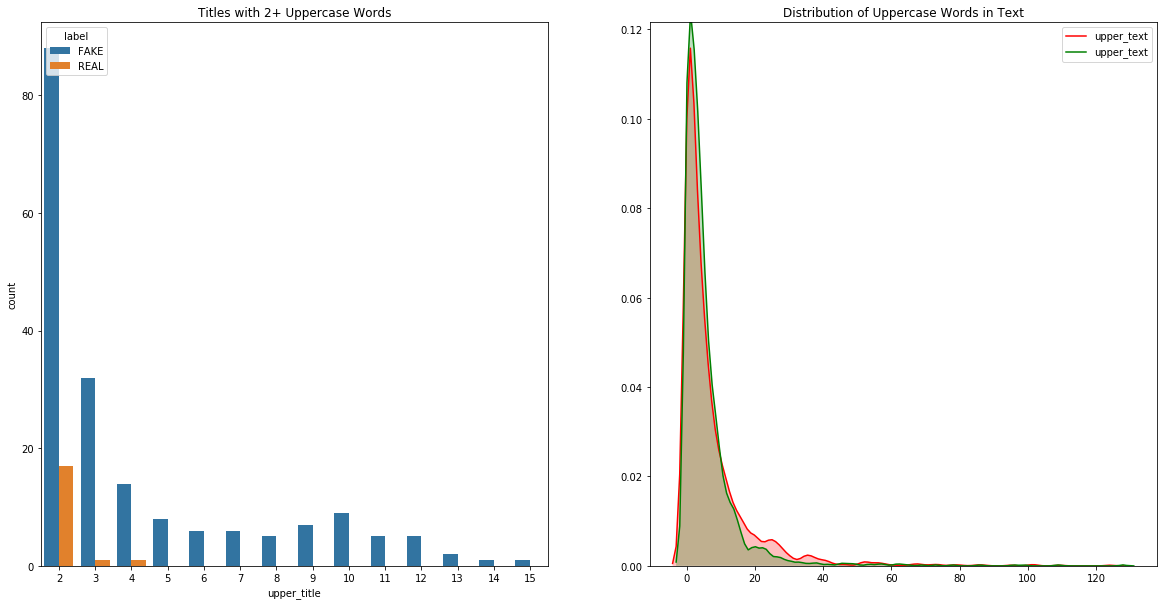

In [20]:
# Plot results with labels 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.countplot(x = train2['upper_title'][train2['upper_title'] > 1], hue = train2["label"]).set_title('Titles with 2+ Uppercase Words')
plt.subplot(1,2,2)
sns.kdeplot(train2.loc[train2["label"] == "FAKE",'upper_text'], shade=True, color='r').set_title("Distribution of Uppercase Words in Text")
sns.kdeplot(train2.loc[train2["label"] == "REAL",'upper_text'], shade=True, color='g')

Testing this function on our train set copy and then plotting the results, we see that titles with more than 2+ words in all capitals are labeled 50% or more as fake, and that titles with more than 6+ words in all capitals are 100% labeled as fake. This seems to indicate that it will be a good predictor for fake news, so we will add this to our pipeline later. 

For text, it seems like the function works less well as the distributions for fake news (in red) and real news (in green) are almost identical. This is possibly because with actual article content, there could be legitimate reasons to have all capital letters (for example, some newspaper style conventions list the location of the article in all capitals at the beginning; interview transcripts can have the name of the person speaking in all capitals; and so on.

### 3.2 Counting All Punctuation

Our next area of focus is on punctuation. Our assumption is that punctuation can serve as an indicator for complexity and "realness" -- that is, actual news articles will have complex sentences with a variety of punctuation, as compared to fake news articles. It's likely that this will apply more to the article content than the title, but we create a function to count all punctuation in both *title* and *text* to check.

In [63]:
# Create a set from string.punctuation and update to include missing punctuation
punctuation = set(string.punctuation)
punctuation.update(['’'])

In [22]:
# Lambda function to count all punctuation
train2['punct_title'] = train2['title'].apply(lambda x: len([char for word in x.split() for char in word if char in (punctuation)]))
train2['punct_text'] = train2['text'].apply(lambda x: len([char for word in x.split() for char in word if char in (punctuation)]))

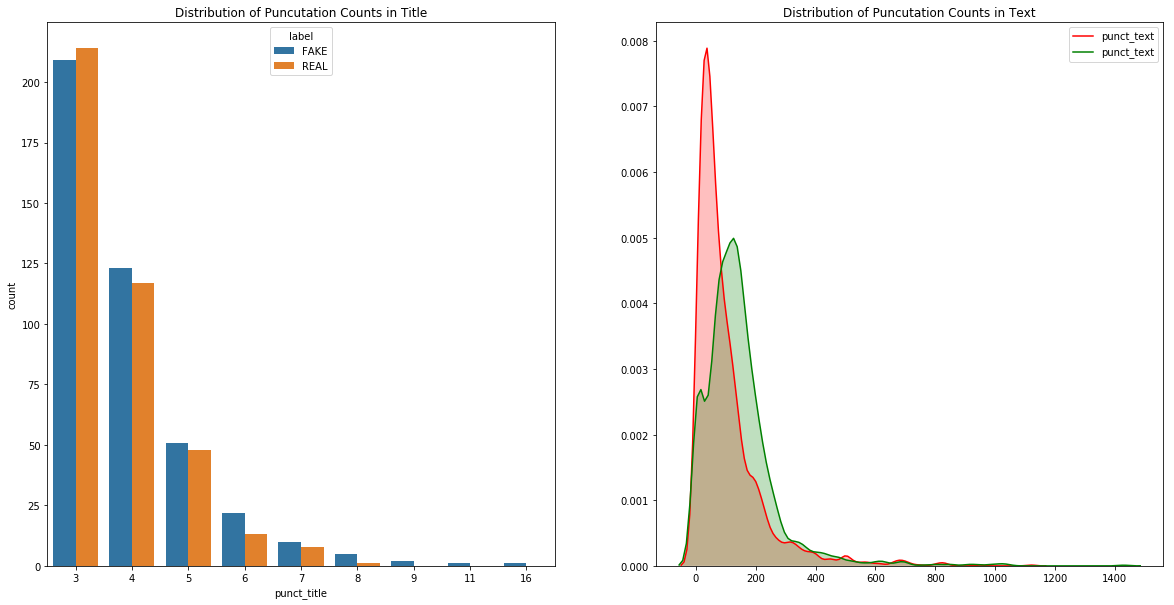

In [23]:
# Plot results with labels 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.countplot(x = train2['punct_title'][train2['punct_title'] > 2], hue = train2["label"]).set_title('Distribution of Puncutation Counts in Title')
plt.subplot(1, 2, 2)
sns.kdeplot(train2.loc[train2["label"] == "FAKE",'punct_text'], shade=True, color='r').set_title("Distribution of Puncutation Counts in Text")
sns.kdeplot(train2.loc[train2["label"] == "REAL",'punct_text'], shade=True, color='g')

Our results show that in *title*, the distributions are fairly similar at the lower end (2-7 punctuation marks), so it doesn't seem helpful here to count all puncutation marks. However, we also notice that more punctuation marks in the title actually seems to be a better indicator of fake news - this makes sense in hindsight as fake news headlines are probably more prone to having exclamation marks for emphasis. Therefore, it might be useful to increase our granularity for *title* and count specific punctuation marks, rather than all of them. 

In *text*, we see that, as expected, real news (the green distribution) tends to have more punctuation marks on average than fake news (the red distribution). So, this seems like a good indicator to add for *text*. 

### 3.3 Counting Exclamation Points

As discussed in the previous results, we want to now check more specific punctuation, such as exclamation points, since our assumption is that they are not frequently used in real reporting, which tends to be more neutral-toned.

In [24]:
# Lambda function for counting exclamation points
train2['exclamation_title'] = train2['title'].apply(lambda x: x.count('!'))
train2['exclamation_text'] = train2['text'].apply(lambda x: x.count('!'))

Text(0.5,1,'Distribution of Exclamation Points in Text')

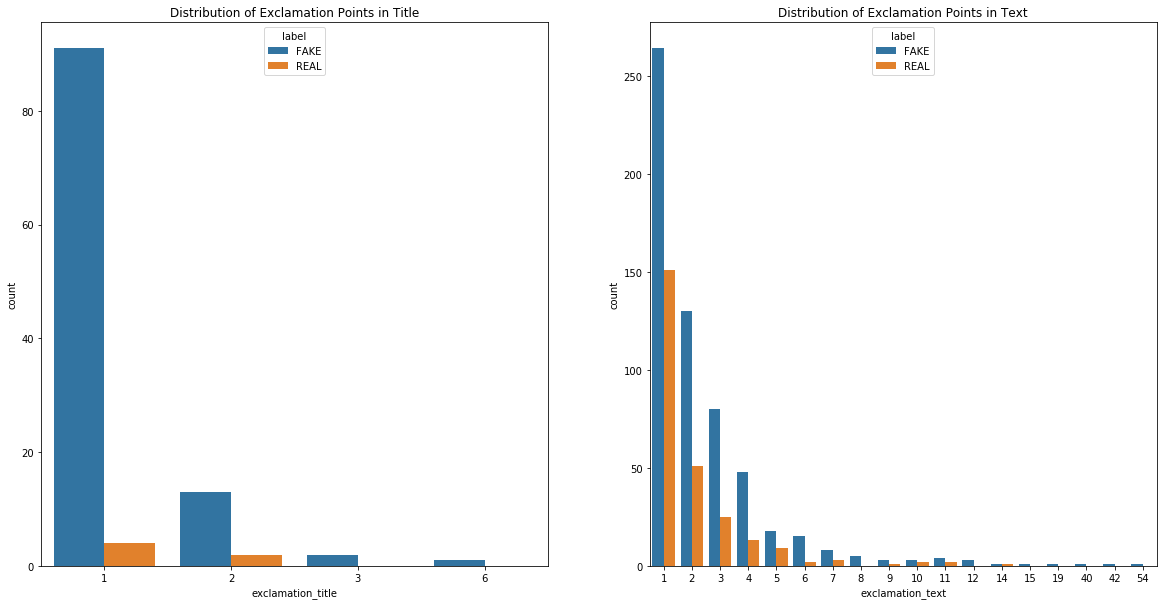

In [25]:
# Plot results with labels 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.countplot(x = train2['exclamation_title'][train2['exclamation_title'] != 0], hue = train2["label"]).set_title('Distribution of Exclamation Points in Title')
plt.subplot(1,2,2)
sns.countplot(x = train2['exclamation_text'][train2['exclamation_text'] != 0], hue = train2["label"], data = train2).set_title('Distribution of Exclamation Points in Text')

Focusing on exclamation points, we see that it is a good predictor for both *title* and *text.* The graphs above show that titles or texts with any number of exclamation points are overwhelmingly classified as fake in the training set.

### 3.4 Counting Semi-colons

It may also be helpful to check specifically for semi-colons, as they tend to indicate more complex sentences, by helping form longer, compound phrases. As stated earlier, we believe language complexity may be a good indicator for real news, so we define a function to count semi-colons and test out this theory on the train set.

In [26]:
# Lambda function for counting semi-colons
train2['semicolon_title'] = train2['title'].apply(lambda x: x.count(';'))
train2['semicolon_text'] = train2['text'].apply(lambda x: x.count(';'))

Text(0.5,1,'Distribution of Semi-colons in Text')

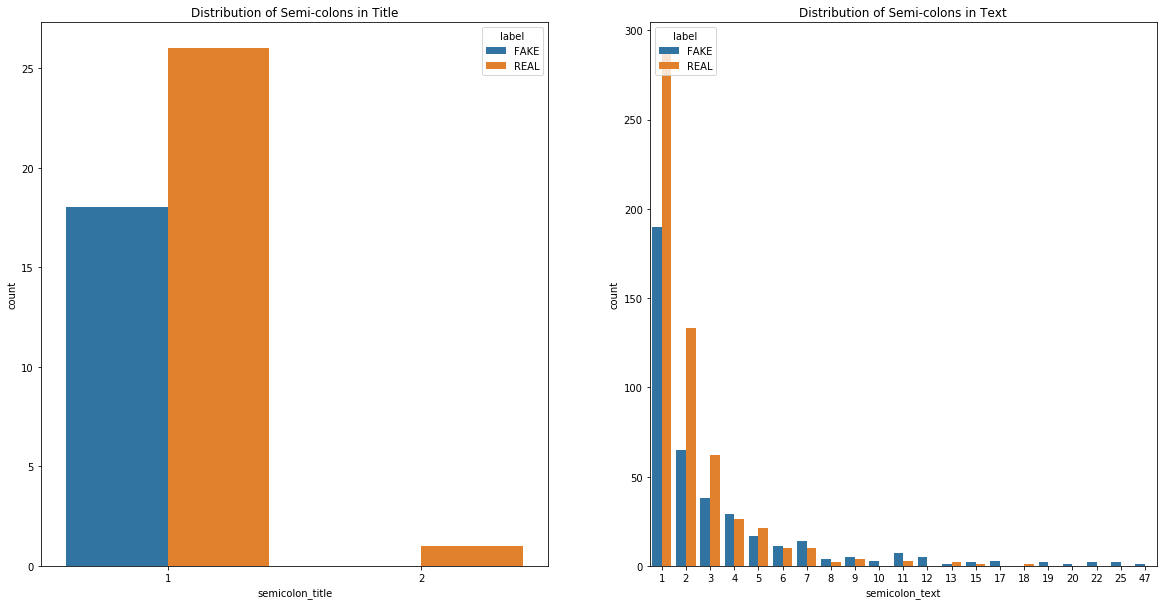

In [27]:
# Test function on train set and plot results with labels 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.countplot(x = train2['semicolon_title'][train2['semicolon_title'] != 0], hue = train2["label"]).set_title('Distribution of Semi-colons in Title')
plt.subplot(1,2,2)
sns.countplot(x = train2['semicolon_text'][train2['semicolon_text'] != 0], hue = train2["label"], data = train2).set_title('Distribution of Semi-colons in Text')

The results are not as conclusive as we like. Though there do appear to be more semi-colons in real news headlines, there are probably too few examples for it to be a useful feature and *text* shows diminishing discriminative power: while real news more commonly has 1-3 semi-colons compared to fake news, it is a roughly equal distribution for higher counts.

We may decide to add this feature later to see if it helps our model, but for now we leave it out.

### 3.5 Word Count

Next, we will take a look at the word counts, excluding any stopwords. Our assumption is that real articles will be longer than fake articles due to their complexity and the extra effort that would have to be spent creating a long fake news article. 

In [65]:
# Create a set of stopwords
stopWords = set(stopwords.words('english'))

In [29]:
# Count words in title and words in title (excluding stopwords)
train2['title_words_not_stopword'] = train2['title'].apply(lambda x: len([t for t in x.split() if t not in stopWords]))
train2['text_words_not_stopword'] = train2['text'].apply(lambda x: len([t for t in x.split() if t not in stopWords]))

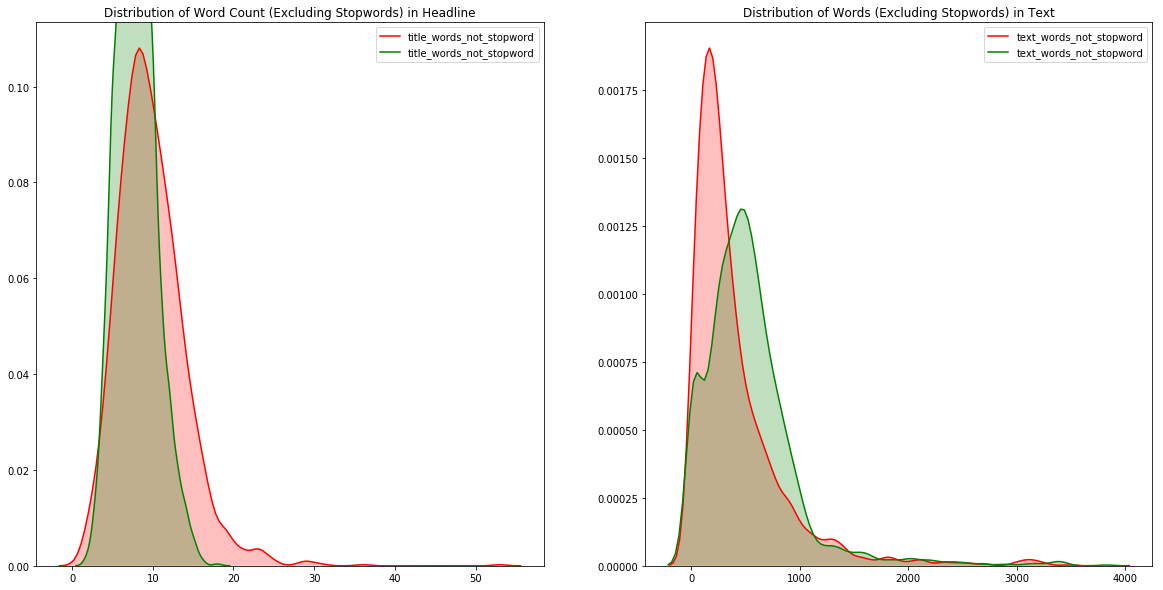

In [30]:
# Plot results with labels 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.kdeplot(train2.loc[train2["label"] == "FAKE",'title_words_not_stopword'], shade=True, color='r').set_title("Distribution of Word Count (Excluding Stopwords) in Headline")
sns.kdeplot(train2.loc[train2["label"] == "REAL",'title_words_not_stopword'], shade=True, color='g')
plt.subplot(1,2,2)
sns.kdeplot(train2.loc[train2["label"] == "FAKE",'text_words_not_stopword'], shade=True, color='r').set_title("Distribution of Words (Excluding Stopwords) in Text")
sns.kdeplot(train2.loc[train2["label"] == "REAL",'text_words_not_stopword'], shade=True, color='g')

Here we see that fake news headlines has a wider distribution of word count with longer tails whereas real news headlines tend to be shorter, with an average word length of 10 words. 

In the text, we see the reverse: fake news has the more narrow distribution and tends to have fewer words on average. We will thus test word count as a feature for both *title* and *text*.

### 3.6 Average Word Length

We also take a look at average word length as a proxy for language complexity. 

In [31]:
# Calculate average word length
train2['title_avglen'] = train2['title'].apply(lambda x: np.mean([len(t) for t in x.split() if t not in stopWords]) 
                                                if len([len(t) for t in x.split() if t not in stopWords]) > 0 else 0)
train2['text_avglen'] = train2['text'].apply(lambda x: np.mean([len(t) for t in x.split() if t not in stopWords]) 
                                              if len([len(t) for t in x.split() if t not in stopWords]) > 0 else 0)

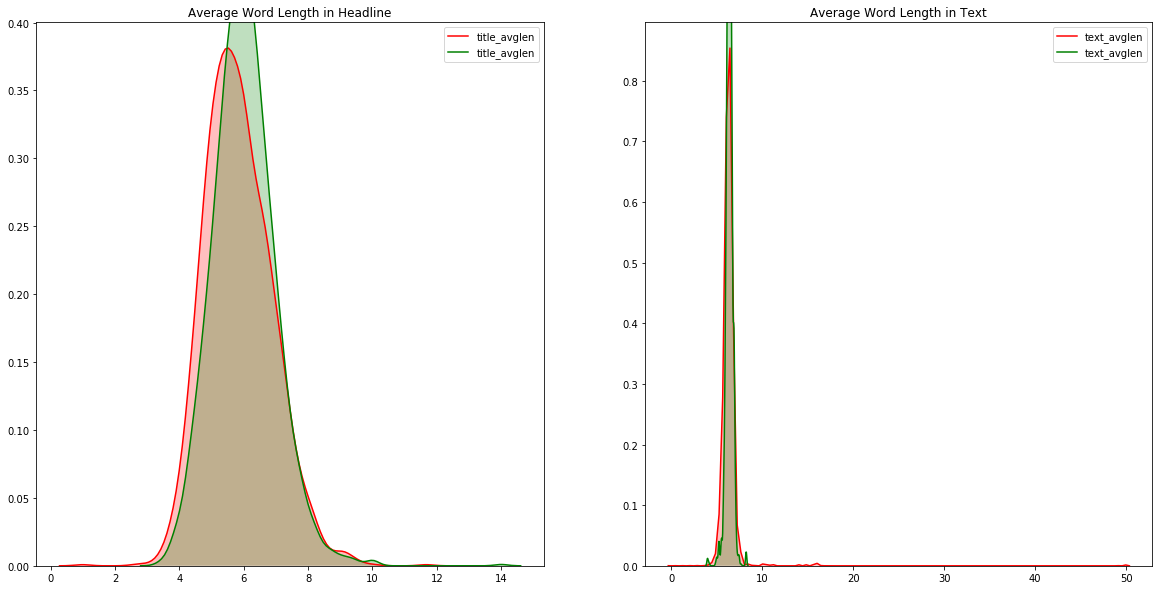

In [32]:
# Test function on train set and plot results with labels 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.kdeplot(train2.loc[train2["label"] == "FAKE",'title_avglen'], shade=True, color='r').set_title("Average Word Length in Headline")
sns.kdeplot(train2.loc[train2["label"] == "REAL",'title_avglen'], shade=True, color='g')
plt.subplot(1,2,2)
sns.kdeplot(train2.loc[train2["label"] == "FAKE",'text_avglen'], shade=True, color='r').set_title("Average Word Length in Text")
sns.kdeplot(train2.loc[train2["label"] == "REAL",'text_avglen'], shade=True, color='g')

Here, there does not appear to be a significant difference in the distributions of average word length in title or text, so we will not use this as a predictor.

### 3.7 Checking Most Common Words

Finally, we want to pull the most common words from titles and texts labeled as fake and titles and texts labeled as real. This may help to reveal some words that are particularly indicative of fake or real news. 

**NOTE**: When we first checked the top 30 words, we found that there were some stopwords and punctuation not included in our sets, so went back and updated these sets. 

In [66]:
# Add more entries to stopWords and punctuation sets
stopWords.update(['the', 'i' 'it', "it’s"])
punctuation.update(['–', '—', '--'])

In [34]:
# Define function to create a list of words (excluding stop words and punctuation and converting to lower case)
def createList(label, field, listname):
    
    for i in range(len(train2)):
        if(train2.loc[i, 'label']==label):
            for j in train2.loc[i, field].split():
                if j.lower() not in stopWords and j not in punctuation:
                    listname.append(j.lower())
                    
    return listname

In [35]:
# Call function to create four lists for fake and real title and text
textlist_real = []
textlist_fake = []
titlelist_real = []
titlelist_fake = []

textlist_real = createList('REAL', 'text', textlist_real)
textlist_fake = createList('FAKE', 'text', textlist_fake)
titlelist_real = createList('REAL', 'title', titlelist_real)
titlelist_fake = createList('FAKE', 'title', titlelist_fake)

In [36]:
# Use FreqDist to display top 30 words for real and fake text
print("TOP 30 REAL TEXT")
wordfreqdist_r = nltk.FreqDist(textlist_real)
mostcommon_r = wordfreqdist_r.most_common(30)
print(mostcommon_r)
print("\n")
print("TOP 30 FAKE TEXT")
wordfreqdist_f = nltk.FreqDist(textlist_fake)
mostcommon_f = wordfreqdist_f.most_common(30)
print(mostcommon_f)

TOP 30 REAL TEXT
[('trump', 6856), ('said', 6749), ('would', 4782), ('clinton', 4479), ('new', 3605), ('one', 3572), ('also', 3068), ('people', 3019), ('republican', 3008), ('president', 2926), ('said.', 2815), ('obama', 2675), ('state', 2635), ('campaign', 2629), ('could', 2508), ('like', 2185), ('even', 2149), ('two', 2112), ('many', 1958), ('political', 1942), ('first', 1924), ('presidential', 1921), ('democratic', 1898), ('u.s.', 1855), ('going', 1791), ('last', 1782), ('party', 1774), ('house', 1748), ('told', 1742), ('states', 1705)]


TOP 30 FAKE TEXT
[('clinton', 3081), ('would', 2963), ('trump', 2915), ('one', 2733), ('people', 2566), ('us', 2305), ('hillary', 2287), ('new', 2082), ('also', 1880), ('like', 1837), ('even', 1736), ('said', 1648), ('could', 1537), ('many', 1490), ('american', 1374), ('2016', 1353), ('government', 1349), ('election', 1311), ('time', 1287), ('state', 1268), ('get', 1236), ('u.s.', 1216), ('first', 1210), ('two', 1179), ('president', 1146), ('world'

The results show a lot of similarities in the top 30 words in real text and fake text. For example, "Trump" is the most common word in real text, but it is also the third most common word in fake text. Many of the top words in both sets appear to be election-related, which could reflect when this sample was taken.

In the end, there doesn't seem to be too many differences in the top 30 words.

In [37]:
# Use FreqDist to display top 30 words for real and fake titles
print("TOP 30 REAL TITLE")
wordfreqdist_r = nltk.FreqDist(titlelist_real)
mostcommon_r = wordfreqdist_r.most_common(30)
print(mostcommon_r)
print("\n")

print("TOP 30 FAKE TITLE")
wordfreqdist_f = nltk.FreqDist(titlelist_fake)
mostcommon_f = wordfreqdist_f.most_common(30)
print(mostcommon_f)

TOP 30 REAL TITLE
[('trump', 281), ('clinton', 178), ('gop', 137), ('obama', 128), ('donald', 118), ('hillary', 98), ('new', 88), ('debate', 80), ('2016', 71), ('sanders', 59), ('iran', 58), ('says', 58), ('house', 58), ('deal', 55), ('republicans', 54), ('cruz', 53), ('us', 51), ('could', 50), ('white', 50), ('campaign', 49), ('state', 46), ('(+video)', 44), ('republican', 39), ('presidential', 39), ("trump's", 39), ('democratic', 38), ('bernie', 36), ('bush', 36), ('isis', 35), ('rubio', 35)]


TOP 30 FAKE TITLE
[('trump', 225), ('hillary', 212), ('clinton', 171), ('election', 94), ('new', 92), ('us', 83), ('fbi', 74), ('comment', 74), ('news', 63), ('russia', 59), ('war', 56), ('donald', 55), ('world', 45), ('u.s.', 37), ('says', 35), ('police', 34), ('email', 34), ('emails', 34), ('america', 33), ('obama', 31), ('campaign', 31), ('wikileaks', 30), ('american', 30), ('one', 29), ('people', 28), ('could', 28), ('source', 27), ('re:', 27), ('black', 27), ('media', 27)]


Again, we see a lot of similarities in the top 30 words in real headlines and fake headlines. In fact, Trump is the most common word in both. 

Here though, we see some slightly different themes, as in fake headlines, "email", "emails", "Russia", and "wikileaks" all appear very frequently, but do not make the top 30 for real headlines. These words refer to popular scandals in 2016, so it makes sense that fake news would focus more on these words than real news. It could be interesting then to look at topics in headlines to separate real and fake news. 

**Summary of Textual Features**

Here are the features that we found helpful in distinguishing fake from real news in the training set:
- Capital Letters: Title
- All Puncutation Count: Text
- Exclamation Count: Title and Text
- Word Count: Title and Text

And for possible further exploration:
- Topic classification for Title

## 4. Models Using Only Existing Fields

Now we are ready to start creating models. Though in Section 3, we identified some potential new features we could add, as our baseline, we will start with only our existing fields, *title* and *text*, and see how these perform.

### 4.1 Pre-processing

In [19]:
# Create a copy of train called df
df = train.copy()
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


There are a few different ways of dealing with *title* and *text*. We can train a model only on one of these fields, train a model on a combination of these fields, or train separate models on each field and combine them on an ensemble. We will test out results with these different methods, so we need to create a concatenated field that includes everything from *title* and *text.*

In [20]:
# Create new field that concatenates title and text
df['title_text'] = df['title'] + ' ' + df['text']

#create new field that is the same as title_text but not cleaned for deep learning
df['title_text_dl'] = df['title_text']

In [21]:
# Create a function to process text
def text_processing(text, split=True, wordtoken=False, alphabet=False, stem=False, lemmatize=False):
    
    # Remove special characters identified earlier
    text = text.replace("\xa0", " ")
    text = text.replace("\n", " ") 
    
    # Remove punctuation and change to lowercase
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator).lower()
    
    # Split by white space (default)
    if split==True:
        text = text.split()
        
    # Split using NLTK default word_tokenizer
    if wordtoken==True:
        text = word_tokenize(text)
    
    # Remove any characters that are not in alphabet
    if alphabet==True:
        text = text.split()
        alpha = []
        for word in text:
            word = re.sub("[^a-z]","", word)
            alpha.append(word)
        text = " ".join(alpha)
    
    if stem==True:
        #stemmer = LancasterStemmer
        #stemmer = PorterStemmer
        stemmer = SnowballStemmer('english')
        stems = []
        for word in text:
            stem = stemmer.stem(word)
            stems.append(stem)
        text = " ".join(stems)
    
    if lemmatize==True:
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in text:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        text = " ".join(lemmas)
        
    return text

In [59]:
# Call function to process text
df['processed'] = df['title_text'].map(lambda x: text_processing(x, stem=True)) 
df.head()

,title,text,label,title_text,title_text_dl,processed
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,You Can Smell Hillary’s Fear Daniel Greenfield...,you can smell hillari fear daniel greenfield a...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,Watch The Exact Moment Paul Ryan Committed Pol...,watch the exact moment paul ryan commit polit ...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,Kerry to go to Paris in gesture of sympathy U....,kerri to go to pari in gestur of sympathi us s...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,Bernie supporters on Twitter erupt in anger ag...,berni support on twitter erupt in anger agains...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,The Battle of New York: Why This Primary Matte...,the battl of new york whi this primari matter ...


Because we don't have labels for the test set, we have to create our own validation sets using the training data.

In [24]:
# Set `y` 
y = df.label 

# Drop the `label` column
df.drop("label", axis=1)

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(df['processed'], y, test_size=0.20, random_state=50)

### 4.2 Multinomial Naive Bayes

We start with one of the most simplistic models, Multinomial Naive Bayes, which calculates probabilities using Bayes Theorem and relies on a naive assumption of feature independence. The data here is typically represented as word vector counts, so we will create a pipeline that first transforms the data using CountVectorizer. 

In [30]:
# Build sklearn pipline for Naive Bayes
text_clf = Pipeline([('vect', CountVectorizer()),
                    #('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

# Run predictions using Naive Bayes
predicted = text_clf.predict(X_test)
score = metrics.accuracy_score(y_test, predicted)
print("Multinomial NB accuracy:   %0.3f" % score)
print("\n")
print(classification_report(y_test, predicted, target_names=['FAKE', 'REAL']))

Multinomial NB accuracy:   0.886


             precision    recall  f1-score   support

       FAKE       0.91      0.86      0.89       406
       REAL       0.87      0.91      0.89       394

avg / total       0.89      0.89      0.89       800



Using Gridsearch, we can play around with hyperparameters to improve our accuracy. Though there are several hyperparameters we can tune, we will focus on n-grams and learning rates.

In [46]:
# Perform gridsearch for best results
parameters = {   
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],   
    'clf__alpha': (0.01, 0.001, 0.0001),  
    }  

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose = 1)
gs_clf = gs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.4min finished


In [47]:
# Bayes Gridsearch Results
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.8911138923654568
{'clf__alpha': 0.01, 'vect__ngram_range': (1, 2)}


We see with gridsearch, we're able to achieve an accuracy score of 89.1%. Not bad for a simple classifier, but we can probably do better.

### 4.3 SGD Classifier

The Stochastic Gradient Descent (SGD) Classifier is a more complex linear classifier that takes longer than Multinomial NB, but works very well with text classification.

In [32]:
# Build sklearn pipeline for SVM
clf_svm = Pipeline([('vect', TfidfVectorizer()),
                         #('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, max_iter=5, random_state=42))])
clf_svm.fit(X_train, y_train)
predicted_svm = clf_svm.predict(X_test)
score = metrics.accuracy_score(y_test, predicted_svm)
print("accuracy:   %0.3f" % score)
print("\n")
phrint(classification_report(y_test, predicted_svm, target_names=['FAKE', 'REAL']))

accuracy:   0.920


             precision    recall  f1-score   support

       FAKE       0.89      0.96      0.92       406
       REAL       0.95      0.88      0.92       394

avg / total       0.92      0.92      0.92       800



With the SGD classifier, we're able to reach 92% using the title_text field and some light pre-processing. With gridsearch, we see that n_grams and adjusting alpha helps adjust the score by a few decimal points. 

In [52]:
# Run GridSearch for SVM
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                  'clf-svm__alpha': (0.01, 0.001, 0.0001)
                 }
gs_clf_svm = GridSearchCV(clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)

# GridSearch results
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.9233416770963705
{'clf-svm__alpha': 0.0001, 'vect__ngram_range': (1, 2)}


### 4.4 Passive Aggressive Classifier

Finally, we will try a newer classifier called the Passive Aggressive Classifier, which is normally used for processing streams such as Twitter data, but can has also shown good performance in other text classification cases.

In [58]:
# Build sklearn pipeline for Passive Aggressive
#stop_words='english',max_df=0.7

clf_passive = Pipeline([('vect', TfidfVectorizer(strip_accents="unicode")),
                    #('tfidf', TfidfTransformer()),
                    ('clf_passive', PassiveAggressiveClassifier(max_iter=15))])
clf_passive.fit(X_train, y_train)
predicted_passive = clf_passive.predict(X_test)
score = metrics.accuracy_score(y_test, predicted_passive)
print("accuracy:   %0.3f" % score)
print("\n")
print(classification_report(y_test, predicted_passive, target_names=['FAKE', 'REAL']))

accuracy:   0.950


             precision    recall  f1-score   support

       FAKE       0.95      0.96      0.95       406
       REAL       0.95      0.94      0.95       394

avg / total       0.95      0.95      0.95       800



The Passive Aggressive Classifier ends up performing extremely well, reaching a 95% accuracy. However, this classifier does not converge, unlike the previous ones, so we do see some variation in our results when we run this classifier.

In [71]:
# Run GridSearch for Passive Aggressive
parameters_passive = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                      'clf_passive__C': (0.01, 0.1, 0.5, 1)
                     }
gs_clf_passive = GridSearchCV(clf_passive, parameters_passive, n_jobs=-1)
gs_clf_passive = gs_clf_passive.fit(X_train, y_train)

# GridSearch results
print(gs_clf_passive.best_score_)
print(gs_clf_passive.best_params_)

0.9292866082603254
{'clf_passive__C': 0.1, 'vect__ngram_range': (1, 2)}


Surprisingly, we see lower accuracy results using gridsearch, but this could be because we are overfitting on our training set and GirdSearchCV helps adjust this overfitting. Therefore, in our out-of-sample testing, it may be preferred to use these parameters. 

### 4.5 Show Most Important Features

To analyze the results of our classifier, we can check for what were the most important features in classifying as fake and real news. Using this function, we checked our results and tried different tactics (such as limiting to only alphabetic characters so that numbers like 2016 are ignored). 

In [380]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

tfidf_vectorizer = clf_svm.named_steps['vect'] # update vector name
classifier = clf_svm.named_steps['clf-svm'] # update classifier name
most_informative_feature_for_binary_classification(tfidf_vectorizer, classifier, n=15)

FAKE -2.05353949349706 hillary
FAKE -1.691490133325795 october
FAKE -1.5495457944857949 2016
FAKE -1.5004087506490937 election
FAKE -1.4315044816227085 by
FAKE -1.2659637646509807 russia
FAKE -1.2465550370234255 fbi
FAKE -1.2152480945373614 article
FAKE -1.17286136696232 war
FAKE -1.1308743795526093 november
FAKE -1.091919050807439 share
FAKE -1.0747460057053815 be
FAKE -1.0690885486153752 mosul
FAKE -1.0435590026237271 comey
FAKE -1.019043743605945 source

REAL 4.095524117426416 say
REAL 1.4452768537168719 that
REAL 1.3910179450139848 he
REAL 1.359572727774473 but
REAL 1.297730904720453 republicans
REAL 1.2952112665464512 obama
REAL 1.2790900309125144 his
REAL 1.273239876063481 gop
REAL 1.2613598660360457 its
REAL 1.2309256332926592 debate
REAL 1.2220080278469527 president
REAL 1.190621729284506 republican
REAL 1.180997337665691 cruz
REAL 1.1801682407918122 iran
REAL 1.1534048558560681 percent


## 5. Models Using New Fields

We were able to get pretty good results with just title + text, but now we will see if we can improve performance by adding new textual features into our pipeline.

In [68]:
# Create a second copy
df2 = train.copy()

# Concatenate title and text again
df2['title_text'] = df2['title'] + ' ' + df2['text']

# and again for deep-learning later
df2['title_text_dl'] = df2['title_text']

We define a function that creates all the relevant textual features we identified earlier in the notebook.

In [71]:
# Create a function to extract relevant textual features
def extract_features(df):
    # call text processing function
    df['processed'] = df['title_text'].map(lambda x: text_processing(x, lemmatize=True)) 
    
    # get number of uppercase words in title
    df['upper_title'] = df['title'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    
    # get number of all punctuation marks in text
    df['punct_text'] = df['text'].apply(lambda x: len([char for word in x.split() for char in word if char in (punctuation)]))
    
    # get number of exclamation points in title and text
    df['exclamations_title'] = df['title'].apply(lambda x: x.count('!'))
    df['exclamations_text'] = df['text'].apply(lambda x: x.count('!'))
    
    # get number of words in title and text (excluding stopwords)
    df['title_words_not_stopword'] = df['title'].apply(lambda x: len([t for t in x.split() if t not in stopWords]))
    df['text_words_not_stopword'] = df['text'].apply(lambda x: len([t for t in x.split() if t not in stopWords]))
    
    return(df)

df2 = extract_features(df2)

We will define different selectors later on for texts and numbers, so we create a list for all features and just numeric features before splitting again into different train and test sets for validation.

In [72]:
# Train/test split
features= [c for c in df2.columns.values if c  not in ['id', 'title', 'text', 'title_text', 'label']]
numeric_features= [c for c in df2.columns.values if c  not in ['id','title','text', 'title_text', 'label','processed']]
target = 'label'

X_train, X_test, y_train, y_test = train_test_split(df2[features], df2[target], test_size=0.20, random_state=50)
X_train.head()

,title_text_dl,processed,upper_title,punct_text,exclamations_title,exclamations_text,title_words_not_stopword,text_words_not_stopword
3234,"American Dream, Revisited Share This: BY PEPE ...",american dream revisit share this by pepe esco...,0,264,0,1,3,928
1951,How come the US keeps killing ISIS No. 2s? On ...,how come the us keep kill isis no 2s on friday...,2,169,0,0,8,489
1940,The Passion Behind Standing Rock Protest The P...,the passion behind stand rock protest the pass...,0,608,0,0,6,2134
2600,Sanders plans Tuesday meeting with Clinton to ...,sanders plan tuesday meet with clinton to disc...,1,90,0,0,12,330
3899,Draft-Dodger Trump Said Sleeping Around Was My...,draftdodger trump say sleep around be my ‘pers...,0,62,0,0,9,260


In [73]:
# Create selector class for text and numbers
class TextSelector(BaseEstimator, TransformerMixin):
    """Transformer to select a single column from the data frame to perform additional transformations on"""
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key."""
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

Now with our selectors and features, we build multiple pipelines so we can deal with each feature: text will be vectorized and each numeric feature will be scaled individually. 

**Note:** Different scalers were tested, but we found the best results with StandardScaler.

In [74]:
# Building pipelines for each feature

# Test different scalers
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

text = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('vect', TfidfVectorizer()),
                #('tfidf', TfidfTransformer())
            ])

text.fit_transform(X_train)

upper_title =  Pipeline([
                ('selector', NumberSelector(key='upper_title')),
                ('standard', scaler),
            ])

punct_text =  Pipeline([
                ('selector', NumberSelector(key='punct_text')),
                ('standard', scaler),
            ])

exclamations_title =  Pipeline([
                ('selector', NumberSelector(key='exclamations_title')),
                ('standard', scaler),
            ])


exclamations_text =  Pipeline([
                ('selector', NumberSelector(key='exclamations_text')),
                ('standard', scaler),
            ])


title_words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='title_words_not_stopword')),
                ('standard', scaler),
            ])

text_words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='text_words_not_stopword')),
                ('standard', scaler),
            ])

Now we use Feature Union to combine all our pipelines together.

In [75]:
# Feature Union
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion([('text', text), 
                      ('upper_title', upper_title),
                      ('punct_text', punct_text),
                      ('exclamations_text', exclamations_text),
                      ('exclamations_title', exclamations_title),
                      ('title_words_not_stopword', title_words_not_stopword),
                      ('text_words_not_stopword', text_words_not_stopword)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<3196x52664 sparse matrix of type '<class 'numpy.float64'>'
	with 1035649 stored elements in Compressed Sparse Row format>

After building our pipeline, we can again test different classifiers for their accuracy scores.

In [76]:
# Function to create predictions
def createPreds(classifier, name):

    pipeline = Pipeline([
        ('features', feats),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_test)
    score = metrics.accuracy_score(y_test, preds)
    print(name + " accuracy:   %0.3f" % score)
    print("\n")
    print(classification_report(y_test, preds, target_names=['FAKE', 'REAL']))

In [81]:
#createPreds(MultinomialNB(), "Multinomial NB")
createPreds(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=42), "SGD")
createPreds(xgboost.XGBClassifier(), "XGB")
createPreds(ensemble.RandomForestClassifier(), "Random Forest")

SGD accuracy:   0.719


             precision    recall  f1-score   support

       FAKE       0.94      0.48      0.63       406
       REAL       0.64      0.97      0.77       394

avg / total       0.79      0.72      0.70       800



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGB accuracy:   0.894


             precision    recall  f1-score   support

       FAKE       0.90      0.89      0.90       406
       REAL       0.89      0.89      0.89       394

avg / total       0.89      0.89      0.89       800

Random Forest accuracy:   0.824


             precision    recall  f1-score   support

       FAKE       0.80      0.88      0.84       406
       REAL       0.86      0.77      0.81       394

avg / total       0.83      0.82      0.82       800



In [79]:
createPreds(PassiveAggressiveClassifier(max_iter=15), "Passive Aggressive")

Passive Aggressive accuracy:   0.906


             precision    recall  f1-score   support

       FAKE       0.96      0.85      0.90       406
       REAL       0.86      0.96      0.91       394

avg / total       0.91      0.91      0.91       800



We see actually that with the features, our SGD classifier performs significantly worse. We test some other classifiers, such as XGBoost and Random Forest to check results as well. Tweaking different parameters and pre-processing steps, we are able to achieve higher results, but they do not surpass our previous record of 95% accuracy.

At the end of the document a list of some results with different combinations of features and classifiers is included. But first we go into deep learning methods.

## 6. Word Embedding



A relatively novel technique in the world of NLP is Word Embedding. Using a deep neural network to map tokenized words (or documents) into vectors. This is an alternative way to vectorize words (like tf-idf or count-vectorizer) that learns the complete feature space of the training set. For example, it should keep the spatial hierarchy of words so that dogs and cats are close to eachother in this high-dimensional vector space. Below we use some techniques for word embedding. Namely, Word2Vec, Fasttext and single embedding layer as part of a full network. We'll first build embeddings to later push into more advanced models.

Also we use some pre-trained word-embeddings. GloVe and Googles Word2Vec pre-trained embedding.

Let's first create a copy of the dataset to work on. Also we set the target variable to numeric so it can be used in the algorithms. Finally we combine the title and text together for experimentation.

In [49]:
#first create a combined text and title attribute to embed
dl_set = df2.copy()
labels = df2.label
dl_set.drop(['label'], inplace = True, axis = 1)

labels2 = [1 if x == 'REAL' else 0 for x in labels]

### 6.1 Tokenizing
To be able to do word-embeddings we first need to tokenizer the texts. We do this with Keras built in tokenizer that gives each token an integer value so it can be fed into an embedding layer.

It should be noted that beside a validation sample we also take a "final_test_sample" this is because when optimizing network architecture for the validation set we are slowly (by hand) overfitting on it. Due to this we take a final test sample to confirm whether our model really is a good model.

In [54]:
maxlen = 2000
max_words = 20000
train_samples = (len(train) - 300)
validation_samples = 200
final_test_samples = 100

#tokenizing
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(dl_set['title_text_dl'])
sequences = tokenizer.texts_to_sequences(dl_set['title_text_dl'])

#creating train, val and test sets
word_index = tokenizer.word_index
print('found {} unique tokens.'.format(len(word_index)))

data = pad_sequences(sequences, maxlen = maxlen)

x_train = data[:train_samples]
y_train = labels2[:train_samples]
x_val = data[train_samples: train_samples + validation_samples]
y_val = labels2[train_samples: train_samples + validation_samples]
x_final_test = data[train_samples + validation_samples:]
y_final_test = labels2[train_samples + validation_samples:]


found 77047 unique tokens.


### 6.2 Local Word-Embedding

First let's build a simple neural network so that we are able to create a word embedding with just our local dataset. Let's embed it in 300 dimensions.

In [135]:
#simple embedding model
model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 300)         6000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 600000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 600001    
Total params: 6,600,001
Trainable params: 6,600,001
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (x_val, y_val))

Train on 3696 samples, validate on 200 samples
Epoch 1/10
3696/3696 [==============================] - 21s 6ms/step - loss: 0.5621 - acc: 0.7362 - val_loss: 0.2340 - val_acc: 0.9250
Epoch 2/10
3696/3696 [==============================] - 19s 5ms/step - loss: 0.0725 - acc: 0.9832 - val_loss: 0.1926 - val_acc: 0.9300
Epoch 3/10
3696/3696 [==============================] - 20s 6ms/step - loss: 0.0212 - acc: 0.9984 - val_loss: 0.1812 - val_acc: 0.9200
Epoch 4/10
3696/3696 [==============================] - 21s 6ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.1798 - val_acc: 0.9300
Epoch 5/10
3696/3696 [==============================] - 23s 6ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.1753 - val_acc: 0.9300
Epoch 6/10
3696/3696 [==============================] - 20s 6ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.1754 - val_acc: 0.9300
Epoch 7/10
3696/3696 [==============================] - 20s 5ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.1804 - val_acc: 0.9300
Epoch 8/

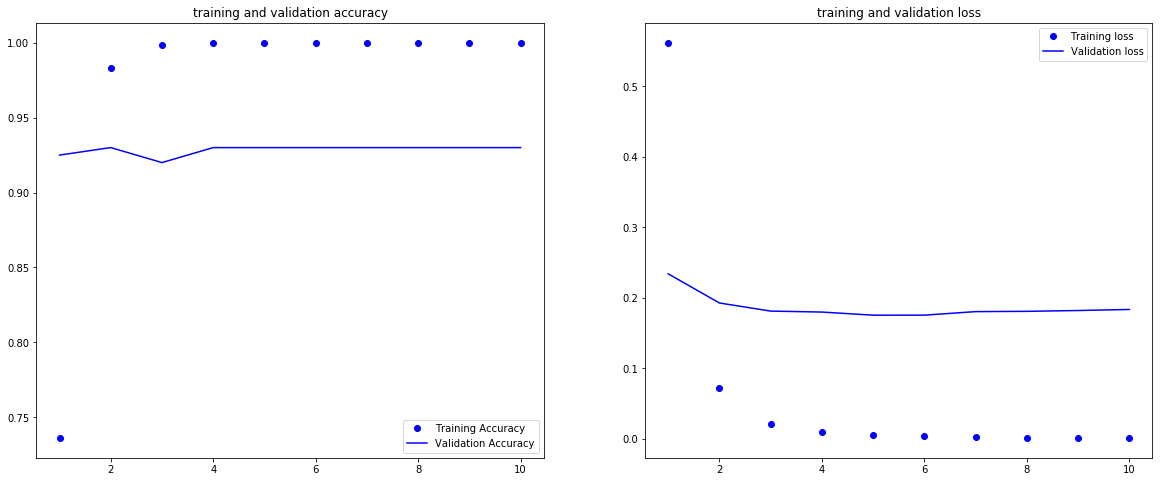

In [150]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title("training and validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("training and validation loss")
plt.legend()

In [151]:
local_embed_weights = model.layers[0].get_weights()[0]

### 6.3 Word2Vec  Word-Embedding

Let's train a local word2vec embedding with the help of Gensim. We have to re-tokenize here with a different strategy becasue Word2Vec takes into the full words completely not the integer values. Also since word2vec and fasttext are unsupervised we will use the complete dataset, not just the train set to train these models.

In [331]:
df['processed'] = df['title_text'].map(lambda x: text_processing(x, lemmatize=True))


dl_set['processed_2'] = dl_set['title_text_dl'].map(lambda x: text_processing(x))
test['processed'] = test['title_text_dl'].map(lambda x: text_processing(x))

combined = pd.concat([dl_set['processed_2'], test['processed']], axis = 0)


In [348]:
combined.reset_index(drop = True, inplace=True)

In [349]:
model_word2vec = Word2Vec(sentences=combined, size=300, window=5, min_count=5, workers=3, sg=0)

Let's save the weights so we can use them later in an embedding layer. We also save the dictionary with the weights and words. We also save the model since it takes a while to train.

In [350]:
w2v_weights = model_word2vec.wv.vectors
model_word2vec.save('word2vec_embedding.h5')

w2v_matrix = dict(zip(model_word2vec.wv.vocab, w2v_weights))

### 6.4 FastText Word-Embedding
We also try the FastText word-embedding. This is an extension of word2vec created by Facebook that doesnt just take the full words into the network but also takes split n-grams from words. (i.e. 'apple' becomes 'app', 'ppl' and 'ple') This increases generalizability to unseen words because the partial n-grams can be used to categorize new words in the correct position of vector space.

In [353]:
model_fasttext = FastText(sentences = combined, size=300, window=5, min_count=5, workers=3, sg=1)

again, we also save the weights and matrix here. We also save the models to drive since they take quite a while to train.

In [354]:
fasttext_weights = model_fasttext.wv.vectors
model_fasttext.save('fasttext_embedding.h5')

fasttext_matrix = dict(zip(model_fasttext.wv.vocab, fasttext_weights))

### 6.5 Pre-trained Word-Embeddings
#### 6.5.1 GloVe

Besides training word-embeddings locally on our (admittedly) small data-set we can also obtain pre-trained word embeddings. First let's take the GloVe pre-trained word embeddings which is trained on the wikipedia corpus. We also obtain the google word2vec pre-trained vectors.

In [156]:
#parsing the GloVe word-embedding file
glove_dir = '/Users/Laurens/Downloads/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('found {} word vectors.'.format(len(embeddings_index)))

found 400000 word vectors.


After reading the data in, we need to create a matrix to store the embedding vectors in. Basically we compare the loaded embeddings with the actual words in our data-set to find matches and put the weights for the words in our data-set in a weight matrix.

In [157]:
#preparing the GloVE word-embeddings matrix

embedding_dim = 300

glove_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            glove_matrix[i] = embedding_vector

#### 6.5.2 Google Word2Vec
A similar approach to loading the GloVe vectors is used here. Except we load the binary with a Gensim function.

In [125]:
google_w2v_dir = 'C:/Users/Laurens/Downloads/GoogleNews-vectors-negative300.bin'

google_w2v_model = KeyedVectors.load_word2vec_format(google_w2v_dir, binary = True)

#filter out words not in the pre-trained model
non_words = []
for word, i in word_index.items():
    if word not in google_w2v_model.vocab:
        non_words.append(word)

In [126]:
embedding_dim = 300

google_w2v_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in non_words:
            pass
        else:
            embedding_vector = google_w2v_model[word]
            if embedding_vector is not None:
                google_w2v_matrix[i] = embedding_vector

## 7. Application of Word Embeddings
We can now do two things with these word embeddings. 

1. We can create feature sets based on the embeddings and push them into traditional models along with our hand-crafted features (naive bayes / svm etc)
2. We can put in the embedding matrices as non-trainable weights in a neural network

First we'll do the first option.

### 7.1 Features from pre-trained google word embeddings

We'll build a feature set by taking the average of the 300 dimensional vectors per document to create 300 colums as features.

In [127]:
def average_embedding(embedding_model):
    row = []
    for idx in dl_set.index:
        #tokenize per row
        tokens = text_to_word_sequence(dl_set.title_text_dl[idx])
    
        #filter out words not in the pre-trained model
        non_words = []
        for word in tokens:
            if word not in embedding_model.vocab:
                non_words.append(word)
    
        # add word2vec vector
        current_word2vec = []
        for _, word in enumerate(tokens):
            if word in non_words:
                pass
            else:
                vec = embedding_model[word]
                if vec is not None:
                    current_word2vec.append(vec)

        averaged_word2vec = list(np.array(current_word2vec).mean(axis=0))
    
    
        row.append(averaged_word2vec)
    dl_set2 = pd.DataFrame(row)
    
    return dl_set2

In [128]:
dl_set2 = average_embedding(google_w2v_model)

Now that we have the features lets concat them to our other feature set.

In [129]:
df_dl = pd.concat([df, dl_set2], axis=1)

Lets split into train and validation sets again.

In [130]:
# Train/test split
features= [c for c in df_dl.columns.values if c  not in ['id', 'title', 'text', 'title_text', 'title_text_dl', 'label']]
numeric_features= [c for c in df_dl.columns.values if c  not in ['id','title','text', 'title_text', 'label','processed']]
target = 'label'

X_train, X_test, y_train, y_test = train_test_split(df_dl[features], df_dl[target], test_size=0.20, random_state=50)
X_train.head()

,processed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
3234,american dream revisit share this by pepe esco...,0.037974,0.021087,0.023142,0.086795,-0.075182,-0.006261,0.039033,-0.082648,0.073866,0.056462,-0.060663,-0.102858,-0.010516,0.047307,-0.096566,0.067973,0.038103,0.087275,0.017543,-0.067174,-0.006135,0.025499,-0.006365,-0.011743,0.045164,0.001705,-0.070220,0.051983,0.047363,-0.005502,-0.017956,-0.020979,-0.038842,0.020367,0.001847,0.001321,0.017538,-0.012215,0.059076,0.048730,0.076468,-0.031881,0.086618,-0.002274,-0.008986,-0.030844,-0.013791,0.027729,0.002332,0.012377,0.012926,0.032886,-0.034604,-0.026843,0.003770,0.051849,-0.034706,-0.071165,0.034344,-0.058100,-0.029374,0.060378,-0.051097,-0.080277,-0.035657,-0.024062,-0.030449,0.104954,-0.039037,0.061080,0.022822,0.023094,0.078701,-0.000572,-0.074886,-0.073167,0.075725,0.094035,0.027988,0.090678,0.023206,-0.050314,0.043447,-0.001540,-0.033007,-0.052194,-0.071854,0.096590,0.002240,0.033430,0.050198,-0.014202,-0.061571,-0.066331,-0.029183,-0.038828,0.037343,0.009983,0.033529,0.005956,-0.026908,-0.028929,0.009171,0.008952,-0.044492,-0.034904,-0.053484,-0.021876,0.020076,-0.060380,-0.046708,-0.009254,-0.033040,0.007017,0.067277,0.020532,0.027055,-0.025571,0.100699,0.063582,-0.080764,-0.001114,-0.051019,0.058737,-0.039272,-0.009419,-0.037415,-0.022805,0.019828,0.021113,-0.020627,-0.063057,-0.071385,-0.011694,-0.010404,-0.059647,0.017967,-0.017696,-0.003576,0.042148,0.044901,-0.069293,0.020471,0.027748,0.043004,-0.003941,-0.020813,-0.035928,-0.044734,0.000680,0.073289,0.025958,-0.065941,0.045946,-0.018295,-0.022164,-0.070221,-0.079902,-0.033644,-0.038317,-0.017374,0.055692,0.011516,0.011150,0.012428,-0.054237,0.043788,-0.031901,0.010327,0.000045,-0.105056,-0.017877,-0.013181,-0.082927,-0.000884,-0.040465,0.044285,-0.100737,-0.005744,-0.021972,-0.067939,-0.053405,-0.008709,-0.007521,-0.000207,-0.007418,-0.030426,0.030917,0.081204,0.088526,0.038298,0.025408,0.015443,-0.004998,-0.052020,0.018857,-0.040348,-6.993087e-07,-0.033781,-0.097700,0.018876,0.052389,-0.024831,-0.007494,-0.004027,-0.006632,-0.004035,-0.007170,-0.012811,-0.015436,-0.041767,0.029405,-0.023341,0.054660,-0.092326,0.008464,0.076251,0.000108,-0.082255,0.016478,-0.013556,0.011966,-0.021658,-0.027264,0.029788,-0.037512,0.057685,0.039908,0.030955,0.009978,0.012314,-0.043916,0.040604,0.012988,0.049655,-0.032602,0.020245,-0.031273,0.080849,-0.005593,0.036880,-0.022134,0.007413,-0.072255,0.002364,0.004321,0.026000,0.053982,-0.003321,-0.010171,0.027936,0.020880,0.027611,0.047365,0.043571,-0.069898,0.035584,0.004696,-0.039209,-0.037678,0.011102,-0.016123,-0.037296,0.062290,0.029777,0.117901,-0.014228,-0.030072,-0.069685,-0.021344,0.022343,0.081043,0.068276,0.019711,0.035596,-0.034048,-0.056353,-0.083265,-0.030184,0.018211,-0.008679,-0.010409,0.013637,0.043040,0.027959,-0.001205,-0.067043,-0.013898,0.019140,0.017414,-0.080210,0.012288,-0.062459,0.026801,-0.025819,-0.002190,0.015858,-0.034080,0

Now we run this new X_train through our pipeline.

In [214]:
#loop over columns to create vector pipelines

vec_cols = X_train.iloc[:, 7:].columns

pipeline_objects = {}
for i in vec_cols:
    x = Pipeline([('selector', NumberSelector(key=i)),
                 ('standard', StandardScaler())])
    
    pipeline_objects[i] = x

Now create a feature union list of all the pipelines.

In [261]:
features2 = []
for i in vec_cols:
    x = (str(i), pipeline_objects[i])
    features2.append(x)
    
    
features2.append(('text', text))
features2.append(('upper_title', upper_title))
features2.append(('punct_text', punct_text))
features2.append(('exclamations_text', exclamations_text))
features2.append(('exclamations_title', exclamations_title))
features2.append(('title_words_not_stopword', title_words_not_stopword))
features2.append(('text_words_not_stopword', text_words_not_stopword))                

In [262]:
feats2 = FeatureUnion(features2)


feature_processing = Pipeline([('feats', feats2)])
feature_processing.fit_transform(X_train)

<3196x52964 sparse matrix of type '<class 'numpy.float64'>'
	with 1994449 stored elements in Compressed Sparse Row format>

In [263]:
# Function to create predictions
def createPreds(classifier, name):

    pipeline = Pipeline([
        ('features', feats2),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_test)
    score = metrics.accuracy_score(y_test, preds)
    print(name + " accuracy:   %0.3f" % score)

In [264]:
#createPreds(MultinomialNB(), "Multinomial NB")
createPreds(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=42), "SGD")
createPreds(svm.SVC(), "SVM")
createPreds(xgboost.XGBClassifier(), "XGB")

SGD accuracy:   0.848
SVM accuracy:   0.776
XGB accuracy:   0.910


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [265]:
createPreds(PassiveAggressiveClassifier(max_iter=50), "Passive Aggressive")

Passive Aggressive accuracy:   0.894


### 7.2 Features from FastText embedding (locally trained)

In [355]:
def average_embedding(embedding_model):
    row = []
    for idx in dl_set.index:
        #tokenize per row
        tokens = text_to_word_sequence(dl_set.title_text_dl[idx])
    
    
        # add word2vec vector
        current_word2vec = []
        for _, word in enumerate(tokens):
            try:
                vec = embedding_model[word]
                current_word2vec.append(vec)
            except KeyError:
                pass

        averaged_word2vec = list(np.array(current_word2vec).mean(axis=0))
    
    
        row.append(averaged_word2vec)
    dl_set2 = pd.DataFrame(row)
    
    return dl_set2

In [356]:
dl_set2 = average_embedding(fasttext_matrix)

In [357]:
df_dl = pd.concat([df, dl_set2], axis=1)

In [358]:
# Train/test split
features= [c for c in df_dl.columns.values if c  not in ['id', 'title', 'text', 'title_text', 'title_text_dl', 'label']]
numeric_features= [c for c in df_dl.columns.values if c  not in ['id','title','text', 'title_text', 'label','processed']]
target = 'label'

X_train, X_test, y_train, y_test = train_test_split(df_dl[features], df_dl[target], test_size=0.20, random_state=50)
X_train.head()

,processed,upper_title,punct_text,exclamations_title,exclamations_text,title_words_not_stopword,text_words_not_stopword,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
3234,american dream revisit share this by pepe esco...,0,264,0,1,3,928,-0.029060,0.262813,0.028895,-0.053993,-0.155644,0.046489,-0.090285,0.040717,-0.103064,0.082956,0.096265,0.004509,0.002342,-0.063160,-0.093250,0.173612,0.093283,-0.004852,0.092280,-0.014807,0.063387,-0.111062,-0.013801,0.077581,-0.043996,-0.124326,-0.025363,0.102139,-0.053335,-0.171291,-0.249392,0.184054,0.099938,0.113063,0.101414,-0.031503,0.143752,0.087203,-0.115925,0.018336,0.059735,0.075665,-0.173658,-0.099341,0.034209,0.037886,-0.016914,0.139968,0.110580,-0.116628,-0.134441,0.178673,-0.066990,0.103288,0.140362,0.239873,-0.109072,0.018805,0.113582,-0.020808,-0.068394,0.016475,0.049198,0.006792,0.140220,0.179003,0.089782,-0.109666,0.024840,-0.117209,-0.127564,-0.064788,0.113336,0.094503,-0.027753,-0.062281,0.063231,-0.080913,-0.038272,0.006708,-0.026983,0.031200,0.203714,0.058342,0.000680,-0.084943,0.053921,0.024037,-0.075880,0.254407,-0.075799,0.092181,-0.012222,-0.119286,-0.024466,-0.010268,-0.215585,0.007618,-0.009601,-0.012945,-0.094931,0.075473,-0.008345,0.025874,-0.024593,0.051514,-0.114906,-0.164143,-0.016341,0.146473,0.083716,-0.087628,0.081887,0.005411,0.172319,0.063738,0.013479,0.081939,-0.113816,-0.037009,0.023807,0.142048,-0.191278,-0.157664,0.132995,-0.031015,0.097196,0.007704,0.052090,0.090805,0.042191,0.039895,-0.046047,0.085627,0.168776,-0.132656,0.043903,-0.163664,-0.080041,-0.110324,0.225299,0.030891,-0.144525,0.111053,-0.038597,0.206366,-0.176161,0.004141,0.144897,0.181450,-0.083932,0.042650,-0.036022,-0.152629,0.189647,-0.066414,-0.039026,0.045883,-0.170797,0.066263,0.017896,0.218193,0.005620,-0.039665,0.043418,-0.051025,0.057851,0.090266,0.156490,0.038071,-0.099175,-0.008203,-0.076576,-0.078165,0.050520,-0.016582,0.018596,0.042092,0.051717,-0.025375,0.154148,0.052212,-0.042186,0.000932,0.062972,0.001046,0.059551,-0.026618,0.040228,-0.007688,0.000533,-0.001839,0.277493,-0.078879,-0.025478,0.042155,0.025554,0.094625,0.114259,0.088034,0.004849,0.021931,-0.037367,-0.130848,0.107811,-0.002127,-0.007767,-0.139064,-0.014392,0.072805,0.042799,0.136825,0.059483,0.089252,-0.099876,-0.168668,-0.057021,0.039453,0.022164,-0.201463,0.040234,-0.085457,0.049560,0.118622,-0.130828,0.009349,-0.032052,-0.133606,-0.054132,0.103156,0.162023,0.056345,0.130452,-0.037396,-0.033981,0.048401,0.066102,-0.169758,0.073038,-0.154140,-0.009903,-0.073078,0.057828,0.099926,0.174940,0.040863,-0.058144,0.075869,0.058382,0.071329,-0.008704,-0.108590,-0.172243,0.004283,0.072474,-0.008869,-0.050767,-0.108056,-0.115707,0.045706,-0.066489,0.052573,-0.021903,0.031814,-0.007604,-0.184060,-0.222010,-0.088432,-0.191284,0.043599,-0.144573,0.037609,-0.045158,-0.240181,0.069591,-0.094924,0.046717,0.021050,-0.037555,-0.132900,-0.010955,0.024733,0.019025,-0.051163,-0.046245,-0.140675,0.170046,0.1

In [359]:
#loop over columns to create vector pipelines

vec_cols = X_train.iloc[:, 7:].columns

pipeline_objects = {}

for i in vec_cols:
    x = Pipeline([('selector', NumberSelector(key=i)),
                 ('standard', StandardScaler())])
    
    pipeline_objects[i] = x
        
features2 = []
for i in vec_cols:
    x = (str(i), pipeline_objects[i])
    features2.append(x)
    
features2.append(('text', text))
features2.append(('upper_title', upper_title))
features2.append(('punct_text', punct_text))
features2.append(('exclamations_text', exclamations_text))
features2.append(('exclamations_title', exclamations_title))
features2.append(('title_words_not_stopword', title_words_not_stopword))
features2.append(('text_words_not_stopword', text_words_not_stopword))  
    
feats2 = FeatureUnion(features2)


feature_processing = Pipeline([('feats', feats2)])
feature_processing.fit_transform(X_train)

<3196x52964 sparse matrix of type '<class 'numpy.float64'>'
	with 1994449 stored elements in Compressed Sparse Row format>

In [360]:
#createPreds(MultinomialNB(), "Multinomial NB")
createPreds(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=42), "SGD")
createPreds(svm.SVC(), "SVM")
createPreds(xgboost.XGBClassifier(), "XGB")

SGD accuracy:   0.801
SVM accuracy:   0.730
XGB accuracy:   0.902


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [361]:
createPreds(PassiveAggressiveClassifier(max_iter=50), "Passive Aggressive")

Passive Aggressive accuracy:   0.848


### 7.3 Features from GloVe pre-trained embeddings

In [298]:
dl_set2 = average_embedding(embeddings_index)

In [299]:
df_dl = pd.concat([df, dl_set2], axis=1)

In [300]:
# Train/test split
features= [c for c in df_dl.columns.values if c  not in ['id', 'title', 'text', 'title_text', 'title_text_dl', 'label']]
numeric_features= [c for c in df_dl.columns.values if c  not in ['id','title','text', 'title_text', 'label','processed']]
target = 'label'

X_train, X_test, y_train, y_test = train_test_split(df_dl[features], df_dl[target], test_size=0.20, random_state=50)
X_train.head()

,processed,upper_title,punct_text,exclamations_title,exclamations_text,title_words_not_stopword,text_words_not_stopword,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
3234,american dream revisit share this by pepe esco...,0,264,0,1,3,928,-0.096976,0.091502,0.004470,-0.151124,-0.036603,0.066728,-0.077374,0.057465,0.081850,-1.459245,0.066522,0.030432,-0.069336,0.044048,0.071976,0.066579,-0.121891,-0.013524,-0.026266,-0.036112,-0.017619,0.173459,0.172577,0.106063,-0.137872,-0.038074,0.045978,-0.041280,-0.069455,0.070507,-0.006328,0.185161,-0.188467,0.053838,-0.656840,0.072366,0.005915,0.026276,-0.030741,0.014386,0.036545,-0.083793,-0.065662,0.077717,0.093815,0.082800,0.078604,0.132581,-0.117635,0.057848,0.083907,-0.084432,0.041213,-0.069789,-0.035633,0.115960,-0.063461,0.128108,0.124350,0.007635,0.067865,0.007973,0.188997,-0.024995,-0.065812,-0.224340,0.083323,0.075931,0.058965,0.035142,0.047150,0.043730,0.020964,-0.014839,-0.055068,0.002437,0.071210,0.071353,-0.155585,0.004117,-0.105008,-0.128211,0.067403,0.023985,0.080784,0.043789,-0.035361,0.170656,0.059438,0.113092,-0.189324,0.057627,-0.146558,-0.104025,0.014394,0.027660,-0.204105,0.044980,0.033384,-0.290000,0.075394,0.078846,-0.022191,-0.041115,-0.056868,0.055600,0.073732,0.046218,-0.085974,0.119541,-0.002958,-0.110052,-0.099189,-0.136919,0.146655,0.078106,-0.021252,0.020751,-0.008237,-0.232468,-0.014538,-0.095536,0.036728,0.102023,0.002683,-0.037166,0.049063,0.130545,0.045338,0.020711,0.032622,0.101106,0.109512,-0.071763,-0.052568,0.014804,0.012032,-0.002276,-0.025274,0.146201,-0.105446,0.051264,-0.029575,0.116763,-0.192578,-0.089890,0.046291,0.029335,-0.118274,0.063537,0.206601,-0.071228,0.037639,-0.007617,0.239224,0.033027,-0.075566,0.023021,0.038819,-0.084556,0.056760,-0.064534,0.049543,-0.090675,-0.016168,0.059819,-0.005851,0.099014,0.035222,0.116728,0.093769,-0.017135,-0.460726,0.044411,-0.006747,-0.040256,-0.068865,0.039430,-0.034496,0.256203,0.063526,0.056824,0.097098,0.042142,0.003552,-0.054771,-0.153065,0.028492,0.009493,0.088401,-0.043317,0.101890,0.056790,-0.032775,0.000206,-0.046901,0.001986,-0.058853,0.047211,-0.007366,0.779861,-0.055428,0.010141,-0.031764,0.066015,-0.004052,-0.068289,0.096860,-0.026385,-0.030430,-0.051784,0.000021,0.097082,0.030569,0.026387,0.104981,0.056118,0.053263,-0.033773,0.092138,0.081794,-0.055287,-0.161072,0.022641,0.004132,-0.005117,0.059142,0.083489,0.009701,-0.069086,0.014531,0.047380,-0.020800,-0.064728,0.007329,0.078254,0.088613,-0.012843,-0.091503,0.074235,-0.054743,0.050915,0.294798,0.049156,-0.549595,-0.062017,0.149228,-0.017527,0.018504,0.013540,0.011215,-0.054719,-0.038792,-0.013318,0.198669,0.013352,-0.055291,-0.107759,0.092341,0.068279,0.018791,-0.096492,0.055820,0.041345,-0.068304,-0.008304,-0.084469,-0.016115,0.141687,0.056862,0.005230,-0.028790,0.053811,0.103597,-0.005265,0.044695,-1.645021,-0.037279,0.444472,0.052444,-0.127915,-0.056800,0.003325,-0.009391,0.025457,0.072554,-0.043745,0.104373,0.003

In [301]:
#loop over columns to create vector pipelines

vec_cols = X_train.iloc[:, 7:].columns

pipeline_objects = {}

for i in vec_cols:
    x = Pipeline([('selector', NumberSelector(key=i)),
                 ('standard', StandardScaler())])
    
    pipeline_objects[i] = x
        
features2 = []
for i in vec_cols:
    x = (str(i), pipeline_objects[i])
    features2.append(x)
    
features2.append(('text', text))
features2.append(('upper_title', upper_title))
features2.append(('punct_text', punct_text))
features2.append(('exclamations_text', exclamations_text))
features2.append(('exclamations_title', exclamations_title))
features2.append(('title_words_not_stopword', title_words_not_stopword))
features2.append(('text_words_not_stopword', text_words_not_stopword))  
    
feats2 = FeatureUnion(features2)


feature_processing = Pipeline([('feats', feats2)])
feature_processing.fit_transform(X_train)

<3196x52964 sparse matrix of type '<class 'numpy.float64'>'
	with 1994449 stored elements in Compressed Sparse Row format>

In [302]:
#createPreds(MultinomialNB(), "Multinomial NB")
createPreds(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=42), "SGD")
createPreds(svm.SVC(), "SVM")
createPreds(xgboost.XGBClassifier(), "XGB")
createPreds(PassiveAggressiveClassifier(max_iter=50), "Passive Aggressive")

SGD accuracy:   0.864
SVM accuracy:   0.811


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGB accuracy:   0.911
Passive Aggressive accuracy:   0.889


## 7.4 Features from word2vec model (locally trained)

In [362]:
dl_set2 = average_embedding(model_word2vec)

C:\Users\Laurens\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [363]:
df_dl = pd.concat([df, dl_set2], axis=1)

# Train/test split
features= [c for c in df_dl.columns.values if c  not in ['id', 'title', 'text', 'title_text', 'title_text_dl', 'label']]
numeric_features= [c for c in df_dl.columns.values if c  not in ['id','title','text', 'title_text', 'label','processed']]
target = 'label'

X_train, X_test, y_train, y_test = train_test_split(df_dl[features], df_dl[target], test_size=0.20, random_state=50)
X_train.head()

,processed,upper_title,punct_text,exclamations_title,exclamations_text,title_words_not_stopword,text_words_not_stopword,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
3234,american dream revisit share this by pepe esco...,0,264,0,1,3,928,-0.033082,-0.012921,0.064196,-0.398674,-0.263066,-0.212627,0.122246,-0.217441,-0.193781,-0.109597,-0.283204,-0.073961,-0.023216,-0.098367,0.003580,0.014693,0.331326,0.289991,0.289626,0.321969,0.026392,0.231521,-0.113459,-0.158093,0.051830,-0.329558,0.126787,0.111251,0.269086,-0.117141,0.288699,0.066425,0.177195,0.204050,-0.050469,0.024257,0.136002,0.082580,-0.068253,-0.365041,-0.056484,-0.213816,0.159121,-0.141739,0.235842,0.091229,-0.110443,-0.151761,-0.224996,-0.243279,0.064712,-0.186241,-0.038289,-0.093751,0.291376,0.240440,0.128810,-0.044074,0.187868,-0.334750,0.110971,-0.079807,0.070420,-0.129164,0.108419,-0.040040,-0.020446,0.131750,0.160987,0.036138,0.172310,0.066665,0.118890,-0.170962,0.157472,-0.180297,0.111733,-0.095661,0.172018,-0.126826,-0.033658,0.039092,-0.017900,-0.100332,-0.034506,-0.294766,0.064141,-0.212350,0.071474,0.034700,0.148730,-0.138242,-0.020684,0.169064,0.199712,0.027682,-0.060801,0.276950,-0.099757,0.060177,0.015955,0.234588,-0.082483,0.086321,0.078404,0.005690,0.148382,-0.082399,-0.212150,0.169457,0.099640,0.042889,0.228687,0.015858,-0.106985,0.015751,0.027699,-0.027851,0.177348,0.023841,0.018426,0.005616,-0.063455,-0.236702,0.509821,0.104160,0.021158,-0.344288,0.019892,0.037169,0.028578,0.248516,-0.094212,-0.014563,0.175113,0.199727,0.239158,0.033388,0.057062,0.079608,0.012607,0.179716,0.178897,0.103644,0.113006,-0.101173,0.267010,-0.301180,0.021137,0.044950,0.073059,-0.230493,0.034817,-0.108261,0.121311,-0.079760,-0.086382,-0.070225,-0.094468,0.298641,-0.127430,-0.155530,0.055520,0.098023,0.049127,0.077815,-0.222585,-0.029147,-0.112405,0.180256,-0.012276,0.040756,-0.108483,0.246130,-0.088980,0.039089,-0.016202,-0.047936,0.023056,-0.111558,-0.183576,0.133458,0.271332,-0.052884,0.069044,0.051672,0.026237,-0.105507,-0.266196,-0.103713,0.209005,0.036177,0.171277,0.368736,-0.032945,0.065954,-0.009299,-0.136914,-0.319065,-0.215737,-0.074125,-0.011411,0.021930,0.182956,-0.030523,-0.291893,0.204454,-0.097245,0.189959,-0.056571,0.077912,-0.175258,-0.112096,-0.037558,-0.065796,0.123349,0.044831,-0.044313,-0.353090,0.390165,-0.129290,0.215346,0.014481,-0.182388,0.116617,-0.058400,0.030137,-0.078831,-0.169608,0.071992,-0.394388,0.076211,0.106297,-0.282086,0.191163,0.002094,-0.260817,0.181267,-0.371726,-0.031899,0.116758,0.235168,-0.056930,0.100969,0.118863,-0.064524,-0.164170,-0.078054,-0.161591,0.082698,-0.220894,-0.338380,-0.091863,-0.089529,0.076483,0.112471,0.022755,-0.190209,-0.116450,0.244641,-0.086497,0.277113,0.073606,-0.036297,0.027885,-0.068296,0.122744,0.129920,-0.099770,-0.074028,-0.147985,0.142090,-0.185862,-0.113492,0.055754,0.006699,-0.229419,0.183414,-0.091974,-0.021767,-0.082847,-0.138069,-0.097342,-0.160101,-0.163367,-0.106154,-0.0907

In [364]:
#loop over columns to create vector pipelines

vec_cols = X_train.iloc[:, 7:].columns

pipeline_objects = {}

for i in vec_cols:
    x = Pipeline([('selector', NumberSelector(key=i)),
                 ('standard', StandardScaler())])
    
    pipeline_objects[i] = x
        
features2 = []
for i in vec_cols:
    x = (str(i), pipeline_objects[i])
    features2.append(x)
    
features2.append(('text', text))
features2.append(('upper_title', upper_title))
features2.append(('punct_text', punct_text))
features2.append(('exclamations_text', exclamations_text))
features2.append(('exclamations_title', exclamations_title))
features2.append(('title_words_not_stopword', title_words_not_stopword))
features2.append(('text_words_not_stopword', text_words_not_stopword))  
    
feats2 = FeatureUnion(features2)


feature_processing = Pipeline([('feats', feats2)])
feature_processing.fit_transform(X_train)

<3196x52964 sparse matrix of type '<class 'numpy.float64'>'
	with 1994449 stored elements in Compressed Sparse Row format>

In [365]:
#createPreds(MultinomialNB(), "Multinomial NB")
createPreds(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=42), "SGD")
createPreds(svm.SVC(), "SVM")
createPreds(xgboost.XGBClassifier(), "XGB")
createPreds(PassiveAggressiveClassifier(max_iter=50), "Passive Aggressive")

SGD accuracy:   0.877
SVM accuracy:   0.855


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGB accuracy:   0.912
Passive Aggressive accuracy:   0.894


## 8. Deep Learning models
Now we use the word embeddings in various deep learning models. We'll first set a baseline from which we build more complex models down the road.

### 8.1 Baseline

In [51]:
maxlen = 500
max_words = 20000
train_samples = (len(train) - 300)
validation_samples = 200
final_test_samples = 100

#tokenizing
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(dl_set['title_text_dl'])
sequences = tokenizer.texts_to_sequences(dl_set['title_text_dl'])

#creating train, val and test sets
word_index = tokenizer.word_index
print('found {} unique tokens.'.format(len(word_index)))

data = pad_sequences(sequences, maxlen = maxlen)

x_train = data[:train_samples]
y_train = labels2[:train_samples]
x_val = data[train_samples: train_samples + validation_samples]
y_val = labels2[train_samples: train_samples + validation_samples]
x_final_test = data[train_samples + validation_samples:]
y_final_test = labels2[train_samples + validation_samples:]

found 77047 unique tokens.


In [383]:
#defining a simple baseline model

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 6,160,501
Trainable params: 6,160,501
Non-trainable params: 0
_________________________________________________________________


In [384]:
model.layers[0].set_weights([local_embed_weights])
#also set the layer to non-trainable to keep the weights the same
model.layers[0].trainable = False

In [385]:
from keras.callbacks import ModelCheckpoint
saving_dir = 'C:/Users/Laurens/Documents/IE-BIGDATA/Term 3/NLP/Assignment 1/model.hd5'

model_checkpoint = ModelCheckpoint(saving_dir, save_best_only=True, save_weights_only=True, mode ='max')

#now compile and train
model.compile(optimizer = 'adam',
             loss='binary_crossentropy',
             metrics = ['acc'])
history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (x_val, y_val),
                   callbacks = [model_checkpoint])

Train on 3696 samples, validate on 200 samples
Epoch 1/10
3696/3696 [==============================] - 50s 14ms/step - loss: 0.2870 - acc: 0.9040 - val_loss: 0.2852 - val_acc: 0.8900
Epoch 2/10
3696/3696 [==============================] - 59s 16ms/step - loss: 0.2741 - acc: 0.8939 - val_loss: 0.4680 - val_acc: 0.7850
Epoch 3/10
3696/3696 [==============================] - 57s 15ms/step - loss: 0.2044 - acc: 0.9251 - val_loss: 0.2625 - val_acc: 0.9050
Epoch 4/10
3696/3696 [==============================] - 55s 15ms/step - loss: 0.1931 - acc: 0.9299 - val_loss: 0.3777 - val_acc: 0.8950
Epoch 5/10
3696/3696 [==============================] - 55s 15ms/step - loss: 0.2041 - acc: 0.9291 - val_loss: 0.2951 - val_acc: 0.9000
Epoch 6/10
3696/3696 [==============================] - 54s 15ms/step - loss: 0.1831 - acc: 0.9305 - val_loss: 0.3165 - val_acc: 0.8900
Epoch 7/10
3696/3696 [==============================] - 55s 15ms/step - loss: 0.1752 - acc: 0.9370 - val_loss: 0.3133 - val_acc: 0.8800
E

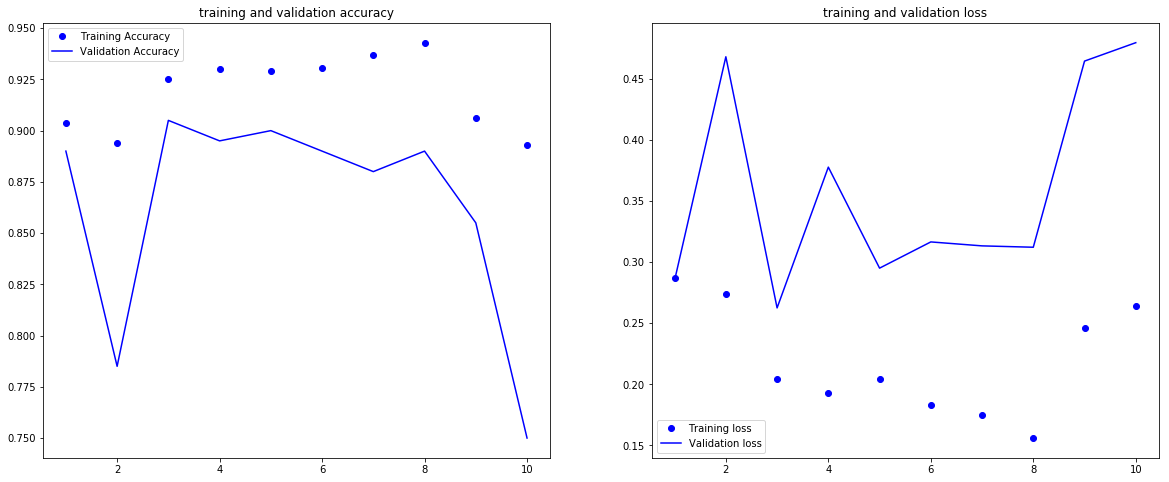

In [386]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title("training and validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("training and validation loss")
plt.legend()

## 8.2 More complex architectures 
Moving towards more complex architectures means that learning locally becomes unfeasible. Due to this we setup a google compute VM instance with 4x vCPU and 2x NVIDIA Tesla p100 GPUs to do parallel learning. First we analyse the setup and then setup parallel processing and finally run some models.

Architectures that we tried are:

- Single LSTM layer (various node counts)
- Single bidrectional LSTM layer (various node counts)
- Single GRU layer (various node counts)
- Single bidirection GRU layer (various node counts)
- 2x LSTM layer (various node counts)
- 2x GRU layer (various node counts)
- 1x CNN1D layer with 1x LSTM layer (various node counts)

We've kept int he notebook for the sake of brevity only the most interesting/well-performing ones.

### 8.2.1 Tensorflow Settings

In [63]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8135353945179254795
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15787999232
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12400651620342927083
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15870181376
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 13949281380540284463
physical_device_desc: "device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"
]


In [64]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

### 8.2.2 Parallel models

In [65]:
model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(Bidirectional(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2)))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               320800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 6,321,801
Trainable params: 6,321,401
Non-trainable params: 400
_________________________________________________________________


In [58]:
#Setting up callbacks
saving_dir = 'best_model.hd5'
model_checkpoint = ModelCheckpoint(saving_dir, save_best_only=True, save_weights_only=True, mode ='max')

#setting up parallel mode
parallel_model = multi_gpu_model(model, gpus=2)


#running model
parallel_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                      metrics = ['acc'])

history = parallel_model.fit(x_train, y_train,
                             epochs = 10,
                             batch_size = 32,
                             validation_data = (x_val, y_val),
                             callbacks = [model_checkpoint])

Train on 3696 samples, validate on 200 samples
Epoch 1/10
3696/3696 [==============================] - 238s 64ms/step - loss: 0.4931 - acc: 0.7465 - val_loss: 0.4955 - val_acc: 0.7400

/home/Laurens/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


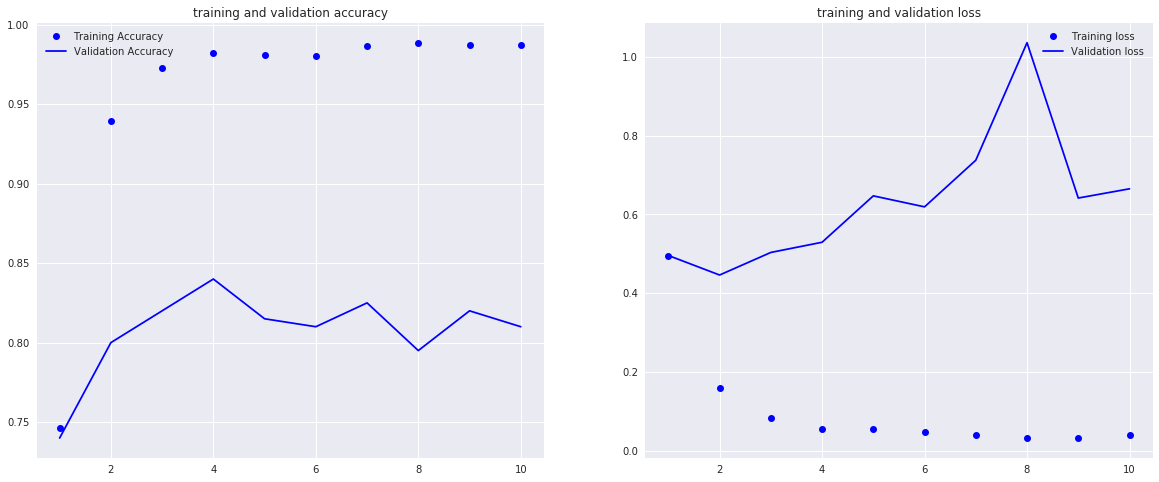

In [59]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title("training and validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("training and validation loss")
plt.legend()

CNN & LSTM models

In [54]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 300, input_length=maxlen))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.summary()

#setting up parallel mode
#parallel_model = multi_gpu_model(model_conv, gpus=2)

saving_dir = 'cnn_best_model.hd5'
model_checkpoint = ModelCheckpoint(saving_dir, save_best_only=True, save_weights_only=True, mode ='max')


#running model
model_conv.compile(loss='binary_crossentropy',
                       optimizer='adam',
                      metrics = ['acc'])

history = model_conv.fit(x_train, y_train,
                             epochs = 10,
                             batch_size = 32,
                             validation_data = (x_val, y_val),
                             callbacks = [model_checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 496, 64)           96064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 6,162,165
Trainable params: 6,162,165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
parallel_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                      metrics = ['acc'])

history = parallel_model.fit(x_train, y_train,
                             epochs = 10,
                             batch_size = 32,
                             validation_data = (x_val, y_val),
                             callbacks = [model_checkpoint])

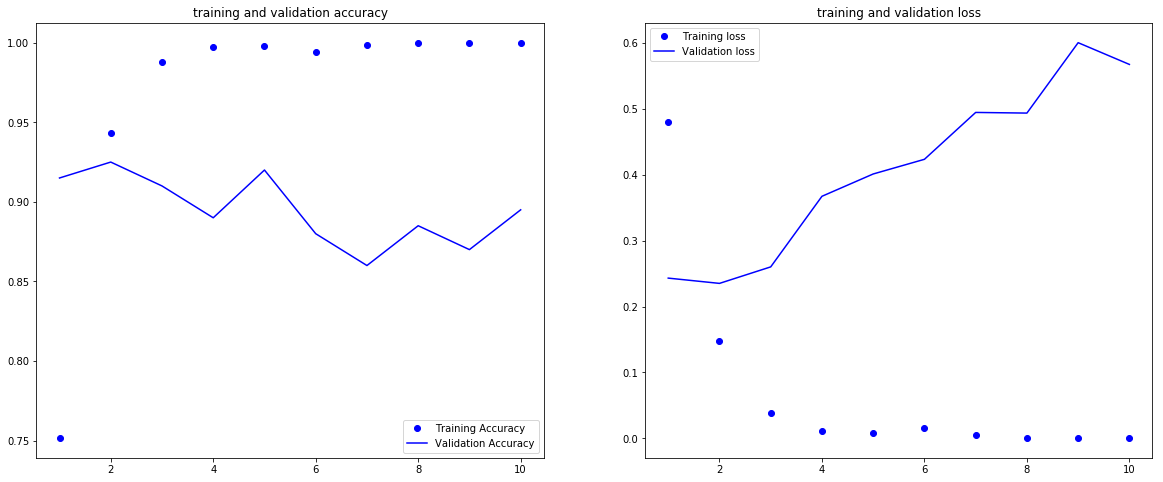

In [55]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title("training and validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("training and validation loss")
plt.legend()

Bigger CNN + LSTM model

In [56]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 300, input_length=maxlen))
model_conv.add(Dropout(0.3))
model_conv.add(Conv1D(128, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Dropout(0.3))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.summary()

#setting up parallel mode
#parallel_model = multi_gpu_model(model_conv, gpus=2)

saving_dir = 'cnn2_best_model.hd5'
model_checkpoint = ModelCheckpoint(saving_dir, save_best_only=True, save_weights_only=True, mode ='max')


#running model
model_conv.compile(loss='binary_crossentropy',
                       optimizer='adam',
                      metrics = ['acc'])

history = model_conv.fit(x_train, y_train,
                             epochs = 10,
                             batch_size = 32,
                             validation_data = (x_val, y_val),
                             callbacks = [model_checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 496, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 124, 128)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 124, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 120, 64)           41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 30, 64)            0         
__________

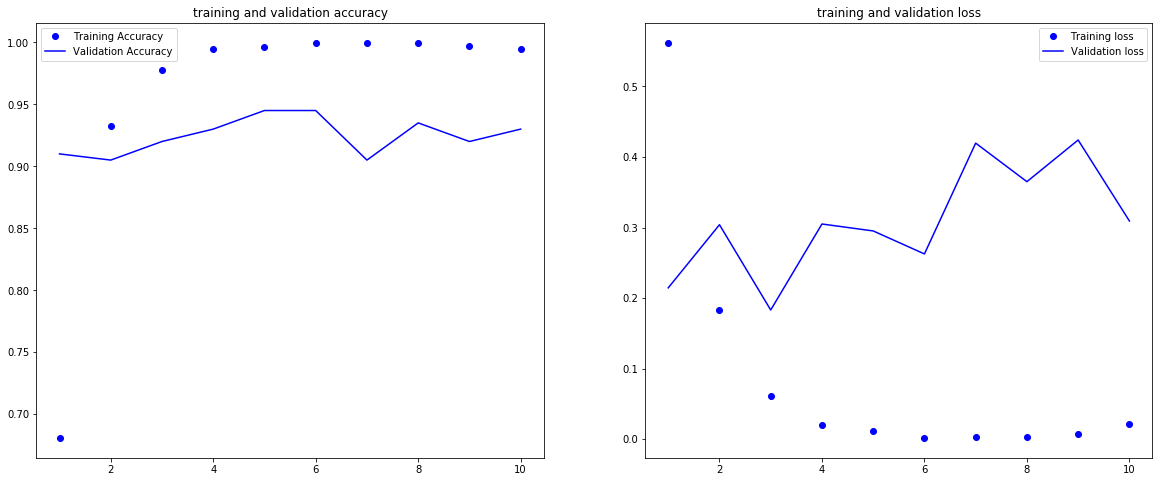

In [57]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title("training and validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("training and validation loss")
plt.legend()

Let's load the weights of this model of the highest scoring epoch (validation accuracy) and check accuracy on the final holdout test set.

In [67]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 300, input_length=maxlen))
model_conv.add(Dropout(0.3))
model_conv.add(Conv1D(128, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Dropout(0.3))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.summary()

model_conv.load_weights('cnn2_best_model.hd5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 496, 128)          192128    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 124, 128)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 124, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 120, 64)           41024     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 30, 64)            0         
__________

Predicting and checking accuracy.

In [112]:
ypred = model_conv.predict_classes(x_final_test)

In [113]:
score = metrics.accuracy_score(y_final_test, ypred)
print("accuracy:   %0.3f" % score)

accuracy:   0.920


So it seems that we get a good score but we are not beating the Passive Aggressive classifier. This is mostly because of the small amount (relatively) of data. Deep learning prefers bigger datasets so that generalizing works better. Below is a summary of the results of the various different model/feature combinations we ran.

## 9. Generate Predictions

As our final model, we generate predictions from our Passive Aggressive Model as this generated the highest validation accuracy.

In [115]:
# Concatenate title and text
test['title_text'] = test['title'] + ' ' + test['text']

In [116]:
# Call function to process text
test['processed'] = test['title_text'].map(lambda x: text_processing(x, stem=True)) 
test_train = test['processed']

In [144]:
# Check shape
print(X_train.shape)
print(len(y_train))

print(test_train.shape)

(3196,)
3196
(2321,)


In [143]:
# Build sklearn pipeline for Passive Aggressive
clf_passive = Pipeline([('vect', TfidfVectorizer(strip_accents = "unicode", ngram_range = (1,2))),
                        ('clf_passive', PassiveAggressiveClassifier(C=0.1, max_iter=50))])
clf_passive.fit(X_train, y_train)
predicted_passive = clf_passive.predict(test_train)

In [142]:
# Export predictions
pd.DataFrame(predicted_passive).to_csv("NLP_FakeNews_predictions_AnniePi_LaurenstenCate.csv")

## Appendix A: Summary of Results

################### initial models ####################

JUST TITLE FIELD
- Multinomial NB + CountVectorizer = 0.809
- SGD + TfIdf Vectorizer = 0.818
- Passive Aggressive + TFIDF Vectorizer = 0.766

JUST TEXT FIELD
- Multinomial NB + TFIDF Vectorizer = 0.770
- Multinomial NB + TFIDF Vectorizer + TFIDF Transformer = 0.779
- Multinomial NB + CountVectorizer = 0.887
- Multinomial NB + CountVectorizer + TfidfTransformer = 0.770
- Multinomial NB + CountVectorizer + Gridsearch = 0.897
- SGD + Count Vectorizer (remove stopwords) = 0.905
- SGD + TFIDF Vectorizer (remove stopwords) = 0.911
- SGD + TFIDF Vectorizer + TfidfTransfromer = 0.897
- SGD + TFIDF Vectorizer + Gridsearch = 0.912
- Passive Aggressive + TFIDF Vectorizer (remove stopwords) = 0.927

TITLE + TEXT FIELDS
- Multinomial NB + CountVectorizer = 0.892
- Mutlinomial NB + processing text = 0.899
- SGD + TFIDF Vectorizer (remove stopwords) = 0.909
- SGD + TFIDF Vectorizer + text processing (stemming) = 0.92
- SGD + TFIDF Vectorizer + features + text processing (lemmatize) = 0.706
- Passive Aggressive + TFIDF Vectorizer = 0.940
- Passive Aggressive + TFIDF Vectorizer + text processing (lemmatize) = 0.943
- Passive Aggressive + TFIDF Vectorizer + features + text processing (lemmatize) = 0.906
- RandomForest + Tfidf Vectorizer + Features + processing (lemmatize) = = 0.824
- XGBoost + Tfidf Vectorizer + Features + processing (lemmatize) = 0.894

################### word embedding features ####################

GOOGLE WORD2VEC PRE-TRAINED VECTORS WITH NORMAL MODELS
- SGD + embedding vectors = 0.834
- SVM + embedding vectors = 0.767
- XGB + embedding vectors = 0.911
- Passive Aggressive + embeddings = 0.887

- SGD + all features = 0.848
- SVM + all features = 0.776
- XGB + all features = 0.910
- Passive Aggresive + all features = 0.894

FASTTEXT LOCALLY TRAINED VECTORS WITH NORMAL MODELS
- SGD + all features = 0.801
- SVM + all features = 0.73
- XGB + all features = 0.902
- Passive Aggresive + all features = 0.848

GLOVE PRE-TRAINED VECTORS WITH NORMAL MODELS
- SGD + all features = 0.864
- SVM + all features = 0.811
- XGB + all features = 0.911
- Passive Aggresive + all features = 0.889

WORD2VEC LOCALLY TRAINED VECTORS WITH NORMAL MODELS
- SGD + all features = 0.877
- SVM + all features = 0.855
- XGB + all features = 0.912
- Passive Aggresive + all features = 0.894

################## pure deep learning models ####################

SIMPLE 1X 100 LSTM
- 0.905

BIDRECTIONAL LSTM 1X100
- 0.84

1X CONV1D + 1X 100 LSTM
- 0.925

2X CONV1D + 1X 100 LSTM
- 0.945